### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from ml_utils import edaDF
import toolbox as tb

In [2]:
# Download and load the data
import keras
import os

f_path_1 = "data/Euro_Salary.csv"
url_1 = "https://github.com/AkeemSemper/ml_data/raw/main/Euro_Salary.csv"
if not os.path.exists(f_path_1):
    file_1 = keras.utils.get_file(f_path_1, url_1)
    
df = pd.read_csv(f_path_1)

### Reload & Display Options

In [3]:
# Reload utility files

import importlib
importlib.reload(tb)

#from ml_eda import edaDF

<module 'toolbox' from 'c:\\Users\\msieb\\OneDrive\\Documents\\1 NAIT\\1 - DATA3950 MACHINE LEARNING\\Repository\\3950-assignment-2-mlsiebold\\toolbox.py'>

In [4]:
# Display options

# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows
#pd.set_option('display.max_rows', None)

# Dispay all output
#pd.set_option('display.max_seq_items', None)            # Not sure this works 

# Change display format for float values (comma seperators, 2 decimals)
pd.options.display.float_format = '{:,.2f}'.format

# Set default figsize for workbook
plt.rcParams["figure.figsize"] = (12,6)

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure you publish it after having run it, all the output should be showing.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a "presentation version" at the bottom, where you show what you did, and the results. Basically, you start with the original data, you do some work to figure out what's needed, you try a few models and select the best. At the bottom, put what <i>you actually settled on</i>, i.e. after all the figuring and exploring, here's the code that goes from raw data to final results, and here's what the results were. I should be able to read this part and understand what you did clearly:
    <ul>
        <li> Please make a pipeline that does the prep work - you may need some exploration or several trials before settling on what exactly to use, that's normal. Once you've settled, build that into a pipeline so it's clear and repeatable.
        <li> What you settled on for data cleaning, along with what prompted it. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Model selection - between selecting a model style and tuning it with hyperparameters, what did you test and what won?
        <li> Overall, how good was your model and what things may make sense to try to do even better? 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

<b>The biggest challenge here is translating the data into something useful and clean. This will probably require a bit of exploration, examining the data, thinking about what it means, trying something, then making a model to see what the results are. In particular, think about what value some of the less clean bits of data my hold - binning/grouping, numerical transformations, outlier removal, etc... are all likely to be useful somewhere. You almost certainly need to look at it column by column and make a decision, I'll apologize up front, it isn't the most fun process in the world. There is not one specific correct answer.</b>

### Basic Cleaning

In [5]:
#  Remove whitespaces and weird characters

import unicodedata

df = df.apply(lambda col: col.map(tb.clean_string))     # Clean entire df
df.columns = df.columns.map(tb.clean_string)            # Clean column headers

In [6]:
# Replace null-like values with NaN

tb.clean_null_like(df, columns=None)

### Data Dictionary

In [7]:
# Create data dictionary

data_dict = pd.DataFrame({
    'Dtype': df.dtypes,
    'Semantic Type': None,
    'Desc': None,
    '# of Nulls': df.isna().sum(),
    '# of Unique Values': df.nunique()
    })                                      #.reset_index(names='Column')

data_dict.index.name = 'Column'             # Give the index a name

In [8]:
# Create description dictionary scaffold to add manually input column descriptions to data dictionary

# Create list of columns
cols = df.columns.to_list()

# Scaffold for descriptions
desc_dict = {col: '' for col in cols}
#desc_dict

# Scaffold for semantics (numeric, categorical)
semantic_dict = {col: '' for col in cols}
#semantic_dict

In [9]:
# Manually update description dictionary

desc_dict = {
 'timestamp': 'Date and time survey response was submitted (acts as survey submission identifier)',
 'age': "Respondent's age in years",
 'gender': "Respondent's self-report gender",
 'city': 'City in which the respondent works (primarily German cities, with a few internationaly cities)',
 'position': 'Current job title or primary role',
 'total years of experience': 'Total number of years the respondent has worked in their profession',
 'years of experience in germany': 'Number of years the respondent has worked specifically in Germany',
 'seniority level': 'Self‑reported seniority',
 'your main technology / programming language': 'Primary programming language or technology used in the respondent’s job',
 'other technologies/programming languages you use often': 'Additional languages, frameworks, or tools the respondent frequently uses',
 'yearly brutto salary (without bonus and stocks) in eur': 'Annual gross base salary in euros, excluding bonuses and stock compensation',
 'yearly bonus + stocks in eur': 'Annual bonus and/or stock compensation in euros',
 'number of vacation days': 'Number of paid vacation days per year',
 'employment status': 'Type of employment',
 'contract duration': 'Type of employment contract',
 'main language at work': 'Primary language used in the workplace',
 'company size': 'Approximate number of employees in the respondent’s company',
 'company type': 'Type of organization respondent is employed for'}

In [10]:
# Manually update semantic type dictionary

semantic_dict = {
 'timestamp': 'categorical nominal',
 'age': 'numeric discrete',
 'gender': 'categorical nominal',
 'city': 'categorical nominal',
 'position': 'categorical nominal',
 'total years of experience': 'numeric continuous',
 'years of experience in germany': 'numeric continuous',
 'seniority level': 'categorical ordinal',
 'your main technology / programming language': 'categorical nominal',
 'other technologies/programming languages you use often': 'categorical nominal',
 'yearly brutto salary (without bonus and stocks) in eur': 'numeric continuous',
 'yearly bonus + stocks in eur': 'numeric continuous',
 'number of vacation days': 'numeric discrete',
 'employment status': 'categorical nominal',
 'contract duration': 'categorical nominal',
 'main language at work': 'categorical nominal',
 'company size': 'categorical ordinal',
 'company type': 'categorical nominal'}

In [11]:
# Map descriptions and semantics to data dictionary 

#data_dict['Desc'] = data_dict['Column'].map(desc_dict)
#data_dict['Semantic Type'] = data_dict['Column'].map(semantic_dict)

data_dict['Desc'] = data_dict.index.map(desc_dict)
data_dict['Semantic Type'] = data_dict.index.map(semantic_dict)

In [12]:
# Check my handywork

data_dict

,Dtype,Semantic Type,Desc,# of Nulls,# of Unique Values
Column,,,,,
timestamp,string[python],categorical nominal,Date and time survey response was submitted (a...,0,1248
age,float64,numeric discrete,Respondent's age in years,27,40
gender,string[python],categorical nominal,Respondent's self-report gender,10,3
city,string[python],categorical nominal,City in which the respondent works (primarily ...,0,106
position,string[python],categorical nominal,Current job title or primary role,6,133
total years of experience,string[python],numeric continuous,Total number of years the respondent has worke...,16,48
years of experience in germany,string[python],numeric continuous,Number of years the respondent has worked spec...,32,52
seniority level,string[python],categorical ordinal,Self‑reported seniority,12,21
your main technology / programming language,string[python],categorical nominal,Primary programming language or technology use...,128,206


In [13]:
# Save data dictionary to markdown file

data_dict.reset_index().to_csv('data_dictionary.tsv', sep='\t', index=False, encoding='utf-8-sig')

### Convert Dtypes

In [14]:
# Change dtypes based on semantic type

df = tb.apply_semantic_dtypes(df, data_dict, tb.semantic_to_dtype)

In [15]:
df.dtypes

Column
timestamp                                                 category
age                                                        float64
gender                                                    category
city                                                      category
position                                                  category
total years of experience                                  float64
years of experience in germany                             float64
seniority level                                           category
your main technology / programming language               category
other technologies/programming languages you use often    category
yearly brutto salary (without bonus and stocks) in eur     float64
yearly bonus + stocks in eur                               float64
number of vacation days                                    float64
employment status                                         category
contract duration                                      

### Define target

In [16]:
df['total_compensation'] = df[['yearly brutto salary (without bonus and stocks) in eur', 'yearly bonus + stocks in eur']].sum(axis=1, skipna=True)

### Create EDA object

In [17]:
target = 'total_compensation'
df_eda = edaDF(data=df, target=target)

### Basic EDA

In [18]:
# Total records

df_length_start = len(df)
df_length_start

1253

In [19]:
# Check for duplicates

df.duplicated().value_counts()

False    1253
Name: count, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 19 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   timestamp                                               1253 non-null   category
 1   age                                                     1226 non-null   float64 
 2   gender                                                  1243 non-null   category
 3   city                                                    1253 non-null   category
 4   position                                                1247 non-null   category
 5   total years of experience                               1230 non-null   float64 
 6   years of experience in germany                          1195 non-null   float64 
 7   seniority level                                         1241 non-null   category
 8   your main technology / progr

In [21]:
# Basic stats

df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Column,,,,,,,,,,,
timestamp,1253,1248,24/11/2020 15:07:35,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,"1,226.00",NaN,NaN,NaN,32.51,5.66,20.00,29.00,32.00,35.00,69.00
gender,1243,3,male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1253,106,berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position,1247,133,software engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total years of experience,"1,230.00",NaN,NaN,NaN,9.08,11.90,0.00,5.00,8.00,12.00,383.00
years of experience in germany,"1,195.00",NaN,NaN,NaN,3.75,3.66,0.00,1.00,3.00,5.00,30.00
seniority level,1241,21,senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
your main technology / programming language,1125,206,python,212,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Number of unique values per feature

print('\033[1m# of unique values:\033[0m')
print(df.nunique())

# of unique values:
Column
timestamp                                                 1248
age                                                         40
gender                                                       3
city                                                       106
position                                                   133
total years of experience                                   42
years of experience in germany                              36
seniority level                                             21
your main technology / programming language                206
other technologies/programming languages you use often     561
yearly brutto salary (without bonus and stocks) in eur     201
yearly bonus + stocks in eur                               162
number of vacation days                                     36
employment status                                           10
contract duration                                            3
main language at work       

In [23]:
# Check for rows missing salary and bonuses

salary = 'yearly brutto salary (without bonus and stocks) in eur'
bonuses = 'yearly bonus + stocks in eur'

len(df[(df[salary].fillna(0)==0) & (df[bonuses].fillna(0)==0)])

0

In [24]:
# Check for rows missing a substantial amount of info

percent = 0.50                              
thresh = round(len(df.columns) * percent)    # Threshold value for missing fields per record

null_count = df.isna().sum(axis=1)          # Count nulls per row

count_empty_drop = len(df[null_count>thresh])

df[null_count>thresh]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
473,25/11/2020 03:27:34,NaN,<NA>,berlin,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"99,999,999,999.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,"99,999,999,999.00"
1180,20/12/2020 00:30:53,NaN,<NA>,berlin,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"30,000.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,"30,000.00"
1181,20/12/2020 00:31:23,NaN,<NA>,berlin,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"111,111.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,"111,111.00"
1231,08/01/2021 12:52:08,NaN,<NA>,munich,<NA>,NaN,NaN,<NA>,<NA>,<NA>,"70,000.00",NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,"70,000.00"


Value counts: 0     641
1     398
2     131
3      48
4      12
7       7
5       5
6       4
15      4
8       1
9       1
10      1
Name: count, dtype: int64


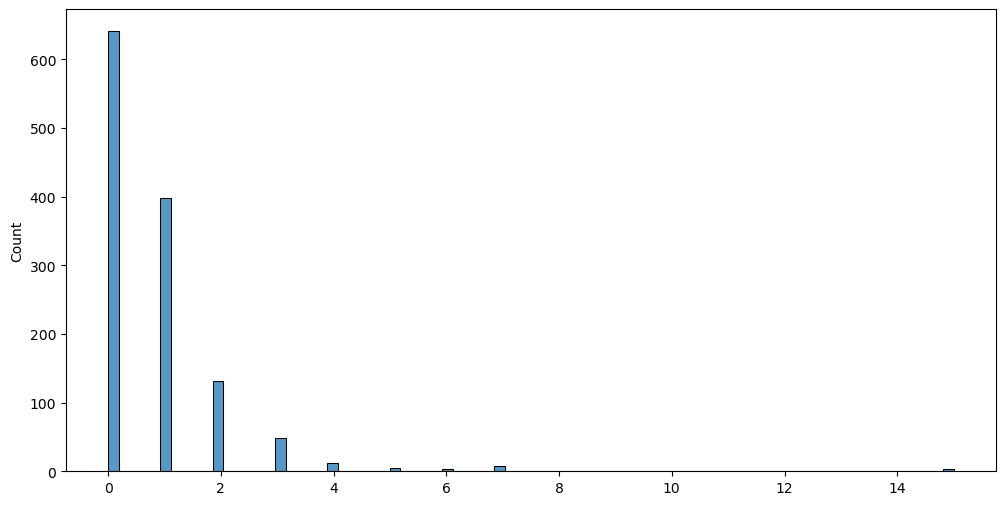

In [25]:
# Check distribution of missingness

sns.histplot(null_count);

print(f'Value counts: {null_count.value_counts()}')


In [26]:
# Drop records with less than 50% of fields completed

df = df[null_count <= thresh].reset_index(drop=True)

In [27]:
# Verify number of rows dropped is correct

df_length_2 = len(df)

df_length_start - (df_length_2 + count_empty_drop)

0

### Column Specific EDA

In [28]:
# Set column lists

num_cols = tb.detect_num_cols(df)
cat_cols = tb.detect_cat_cols(df)

### **'Timestamp'**
- **Inconsistencies:**
    - no value added
- **Actions taken:**
    - drop column

In [29]:
# Basic EDA

column = 'timestamp'
tb.eda_column_summary(df, column)

=== COLUMN: timestamp ===

DTYPE:
category

NON-NULL VALUES:
1,249

NULL VALUES:
0

UNIQUE VALUES:
1,244

BASIC STATS:
count                    1249
unique                   1244
top       24/11/2020 14:07:23
freq                        2
Name: timestamp, dtype: object

TOP VALUES:
timestamp
24/11/2020 14:07:23    2
24/11/2020 15:07:35    2
24/11/2020 13:55:19    2
25/11/2020 08:47:37    2
25/11/2020 18:28:01    2
Name: count, dtype: int64

BOTTOM VALUES:
timestamp
30/11/2020 16:57:51    1
25/11/2020 03:27:34    0
20/12/2020 00:30:53    0
20/12/2020 00:31:23    0
08/01/2021 12:52:08    0
Name: count, dtype: int64


In [30]:
# Check if any duplicate timestamps might be duplicate records

df[df[column].duplicated(keep=False)].sort_values(by=column)

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
234,24/11/2020 13:55:19,25.00,male,munich,ml engineer,1.00,1.00,middle,python,"python, c/c++, swift, matlab","65,000.00","2,000.00",30.00,full-time employee,unlimited contract,english,1000+,product,"67,000.00"
235,24/11/2020 13:55:19,32.00,male,berlin,engineering manager,9.00,5.00,lead,<NA>,"php, javascript / typescript, .net, sql, googl...","95,000.00","140,000.00",365.00,full-time employee,unlimited contract,english,1000+,product,"235,000.00"
246,24/11/2020 14:07:23,34.00,male,berlin,software engineer,14.00,5.00,senior,c#,"javascript / typescript, .net, sql, aws, docker","72,000.00",NaN,26.00,full-time employee,unlimited contract,english,101-1000,product,"72,000.00"
247,24/11/2020 14:07:23,37.00,male,berlin,team lead,12.00,10.00,head,python,"python, php, javascript / typescript, sql, docker","90,000.00",NaN,30.00,full-time employee,unlimited contract,english,11-50,consulting / agency,"90,000.00"
280,24/11/2020 15:07:35,33.00,male,frankfurt,software engineer,10.00,1.00,senior,.net,"javascript / typescript, sql, azure","26,400.00",NaN,NaN,self-employed (freelancer),unlimited contract,english,up to 10,startup,"26,400.00"
281,24/11/2020 15:07:35,28.00,male,berlin,frontend developer,8.00,5.00,senior,javascript,<NA>,"68,000.00",NaN,NaN,full-time employee,<NA>,<NA>,<NA>,<NA>,"68,000.00"
489,25/11/2020 08:47:37,29.00,male,munich,software engineer,8.00,6.00,middle,php,"javascript / typescript, sql","75,000.00",NaN,30.00,full-time employee,unlimited contract,english,1000+,product,"75,000.00"
490,25/11/2020 08:47:37,37.00,male,malta,software architect,18.00,NaN,head,go,"google cloud, kubernetes, docker, shell","156,000.00",0.00,0.00,self-employed (freelancer),unlimited contract,english,11-50,startup,"156,000.00"
664,25/11/2020 18:28:01,32.00,male,berlin,qa engineer,10.00,3.00,senior,js,"java / scala, google cloud, docker","81,000.00","45,000.00",30.00,full-time employee,unlimited contract,english,1000+,product,"126,000.00"
665,25/11/2020 18:28:01,32.00,male,cologne,devops,7.00,2.00,middle,k8s,"python, google cloud, kubernetes, docker","60,000.00",NaN,30.00,full-time employee,unlimited contract,english,101-1000,product,"60,000.00"


In [31]:
# Convert Timestamp to datetime 

df[column] = pd.to_datetime(df[column], errors='coerce', dayfirst=True)

In [32]:
# Look at date ranges

print(f'Oldest date: {df[column].min()}')
print(f'Most recent date: {df[column].max()}')

Oldest date: 2020-11-24 11:14:15
Most recent date: 2021-01-19 12:01:11


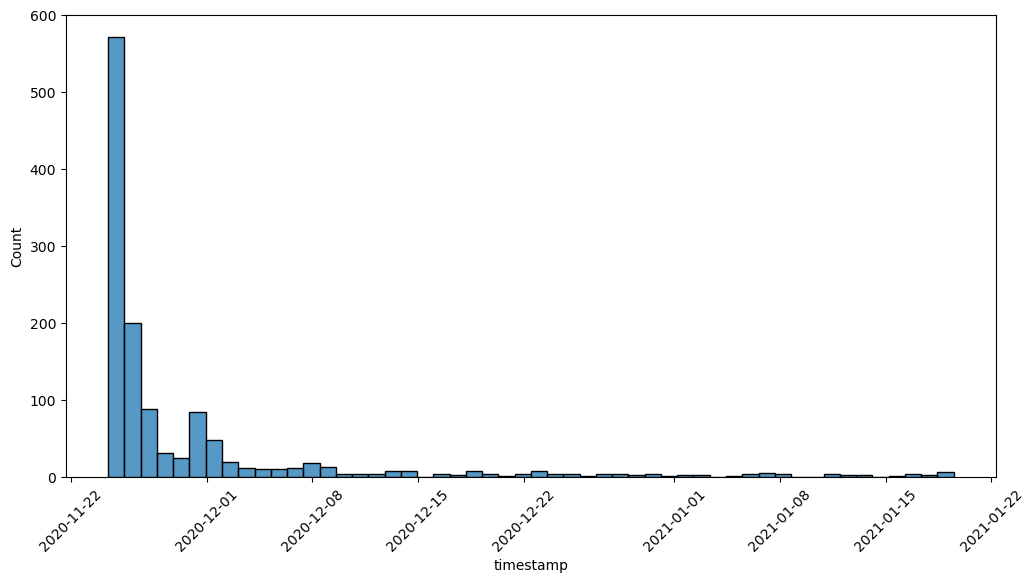

In [33]:
# Check distribution for funzies

sns.histplot(df, x=column)
plt.xticks(rotation=45);

##### **Observations**
- Duplicate Timestamp's look fine. No duplicate records
- Can't see any use for this column so drop it

### **'Age'**
- **Inconsistencies:**
    - null values
    - positive skew 
    - spike in distribution (age=30)
- **Actions taken:**
    - impute null values
    - standardize column (StandardScaler) or bin ages?
    - log transformation

In [34]:
# Basic EDA

column = 'age'
tb.eda_column_summary(df, column)

=== COLUMN: age ===

DTYPE:
float64

NON-NULL VALUES:
1,226

NULL VALUES:
23

UNIQUE VALUES:
40

BASIC STATS:
count   1,226.00
mean       32.51
std         5.66
min        20.00
25%        29.00
50%        32.00
75%        35.00
max        69.00
Name: age, dtype: float64

TOP VALUES:
age
30.00    110
32.00     94
33.00     94
28.00     87
31.00     87
Name: count, dtype: int64

BOTTOM VALUES:
age
50.00    1
21.00    1
20.00    1
69.00    1
52.00    1
Name: count, dtype: int64


In [35]:
# Look at age ranges

print(f'Youngest: {df[column].min()}')
print(f'Oldest: {df[column].max()}')


Youngest: 20.0
Oldest: 69.0


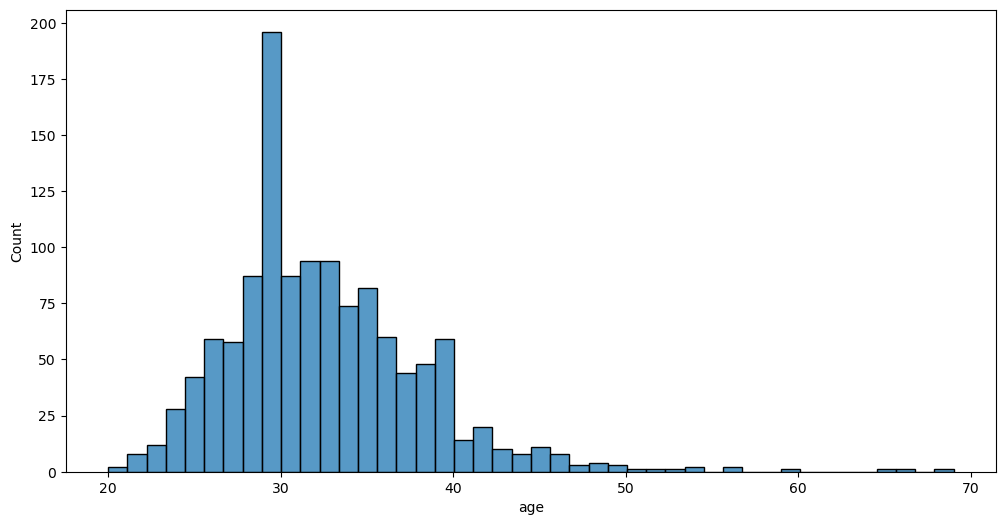

In [36]:
# Check distribution

sns.histplot(df, x=column);

In [37]:
# I wonder what that spike is...

df[column].value_counts().head(1)

age
30.00    110
Name: count, dtype: int64

In [38]:
# Check null records

df[df[column].isna()]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
11,2020-11-24 11:18:16,NaN,male,berlin,software engineer,25.00,11.00,senior,c++,"python, c/c++, sql","100,000.00",101.00,24.00,self-employed (freelancer),temporary contract,english,11-50,product,"100,101.00"
12,2020-11-24 11:18:22,NaN,<NA>,berlin,software engineer,NaN,NaN,lead,php,<NA>,"90,000.00","40,000.00",NaN,full-time employee,unlimited contract,english,1000+,<NA>,"130,000.00"
28,2020-11-24 11:25:35,NaN,male,berlin,devops,14.00,5.00,senior,<NA>,"python, go, aws, kubernetes, docker","67,000.00","7,000.00",30.00,full-time employee,unlimited contract,english,101-1000,product,"74,000.00"
55,2020-11-24 11:33:08,NaN,male,berlin,software engineer,NaN,1.00,senior,php,<NA>,"75,000.00",NaN,NaN,full-time employee,<NA>,english,<NA>,<NA>,"75,000.00"
113,2020-11-24 11:56:25,NaN,male,berlin,qa engineer,6.00,6.00,middle,javascript,"javascript / typescript, aws","50,000.00",NaN,30.00,full-time employee,unlimited contract,english,101-1000,product,"50,000.00"
300,2020-11-24 15:47:19,NaN,male,berlin,data engineer,7.50,1.50,middle,sql,"python, sql, aws, kubernetes, docker","68,000.00",500.00,30.00,full-time employee,unlimited contract,english,101-1000,product,"68,500.00"
330,2020-11-24 17:29:51,NaN,<NA>,munich,data scientist,2.00,2.00,middle,python,<NA>,"54,000.00",NaN,20.00,full-time employee,unlimited contract,english,51-100,product,"54,000.00"
340,2020-11-24 17:40:38,NaN,male,hamburg,support engineer,NaN,2.00,senior,<NA>,"kubernetes, docker","61,000.00",NaN,28.00,full-time employee,unlimited contract,english,<NA>,<NA>,"61,000.00"
365,2020-11-24 18:31:25,NaN,male,berlin,software engineer,9.00,1.00,lead,java,"aws, docker","75,000.00",NaN,24.00,full-time employee,unlimited contract,english,1000+,startup,"75,000.00"
374,2020-11-24 18:48:30,NaN,male,karlsruhe,backend developer,8.00,8.00,lead,python,"python, c/c++, javascript / typescript, java /...","65,000.00","5,400.00",29.00,part-time employee,unlimited contract,english,up to 10,product,"70,400.00"


##### **Observations**
- age range looks good
- positive skew
    - log transformation
- big spike at age 30 (maybe people rounded their age?)
    - try: 
        - standardizing this column (StandardScaler)
        - binning the ages
- don't think I want to drop outliers
- most records with null values in Age feild look ok
    - impute

### **'Gender'**
- **Inconsistencies:**
    - null values
    - 'Diverse' gender has too few values for a predictive model to learn from
        - ethical considerations
- **Actions taken:**
    - drop column

In [39]:
# Basic EDA

column = 'gender' 
tb.eda_column_summary(df, column)

=== COLUMN: gender ===

DTYPE:
category

NON-NULL VALUES:
1,243

NULL VALUES:
6

UNIQUE VALUES:
3

BASIC STATS:
count     1243
unique       3
top       male
freq      1049
Name: gender, dtype: object

TOP VALUES:
gender
male       1049
female      192
diverse       2
Name: count, dtype: int64

BOTTOM VALUES:
gender
male       1049
female      192
diverse       2
Name: count, dtype: int64


Value counts: gender
male       1049
female      192
diverse       2
Name: count, dtype: int64


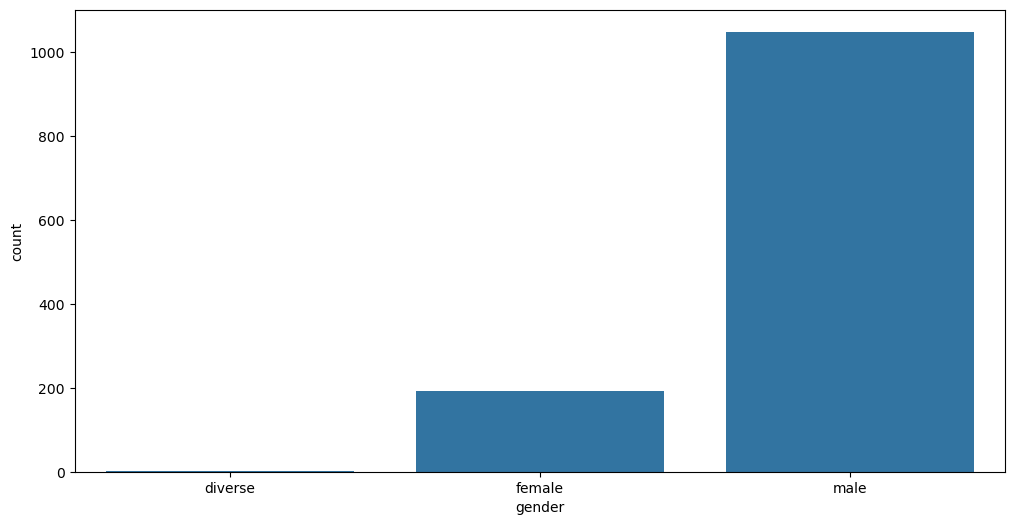

In [40]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')

##### **Observations**
- males dominate the data
- 'diverse' has too few values for a predictive model to learn from 
    - dropping only 'diverse' values creates some ethical concerns...
    - using gender would probably create more accurate predictions, but might be better off excluding it in the name of fairness
    - drop the column

### **'City'**
- **Inconsistencies:**
    - Countries/regions/etc rather than cities
    - Special characters ex. "()"
    - Invalid answers and extra text ("Prefer not to say", "area", "City in")
    - Abreviations
    - Spelling errors
    - Multiple spellings
- **Actions taken:**
    - Replace inconsistent values using mapping dictionary

In [41]:
# Basic EDA

column = 'city'
tb.eda_column_summary(df, column)

=== COLUMN: city ===

DTYPE:
category

NON-NULL VALUES:
1,249

NULL VALUES:
0

UNIQUE VALUES:
106

BASIC STATS:
count       1249
unique       106
top       berlin
freq         678
Name: city, dtype: object

TOP VALUES:
city
berlin       678
munich       235
frankfurt     44
hamburg       40
stuttgart     33
Name: count, dtype: int64

BOTTOM VALUES:
city
tampere (finland)    1
warsaw, poland       1
walldorf             1
wroclaw              1
wurzburg             1
Name: count, dtype: int64


In [42]:
# Import world cities & countries from SimpleMaps

world = pd.read_csv('data/worldcities.csv')   
world = world[['city_ascii', 'country']]

world['city'] = world['city_ascii'].apply(tb.clean_string)
world['country'] = world['country'].apply(tb.clean_string)


In [43]:
# Compare world cities to df

df['is_valid_city'] = df[column].isin(world['city'])
city_no_match_df = df[df['is_valid_city']==False]
city_no_match_list = city_no_match_df[column].unique().tolist()
city_no_match_df[column].value_counts()

city
nurnberg            4
boeblingen          3
saint-petersburg    2
dusseldurf          1
bolingen            1
                   ..
warsaw              0
wolfsburg           0
wroclaw             0
wurzburg            0
zurich              0
Name: count, Length: 106, dtype: int64

In [44]:
# Count of unique City values before replacements

city_len_before = len(df[column].unique())
city_len_before

106

In [45]:
# Convert dtype to string

df[column] = df[column].astype("string")

In [46]:
# Replace invalid categories and values that are not cities

df[column] = df[column].replace({

    # Not a city, replace with largest city in region or country
    'france': 'paris',              
    'fr': 'paris',                 
    'city in russia': 'moscow',     
    'schleswig-holstein': 'kiel',     # german state
    'konstanz area': 'konstanz',    # region
    'bodensee': 'konstanz',         # lake    
    'nj, usa': 'newark',          
    'prefer not to say': None,
    'moldova': 'chisinau',          

    # Cities with extra text     
    'riga, latvia': 'riga',
    'tampere (finland)': 'tampere',
    'warsaw, poland': 'warsaw',

    # Misspellings or alternate spellings
    'boeblingen': 'boblingen',      # SimpleMaps uses 'Boblingen' (ASCII)
    'bolingen': 'boblingen',
    'nurnberg': 'nuremberg',
    'koln': 'cologne',
    'kiev': 'kyiv',
    'den haag': 'the hague',
    'cracovia': 'krakow',
    'cracow': 'krakow',
    'luttich': 'liege',
    'milano': 'milan',
    'dusseldurf': 'dusseldorf',
    'duesseldorf': 'dusseldorf',
    'saint-petersburg': 'saint petersburg'
})

In [47]:
# Compare world cities to df again

df['is_valid_city'] = df[column].isin(world['city'])
city_no_match_df = df[df['is_valid_city']==False]
city_no_match_list = city_no_match_df[column].unique().tolist()
city_no_match_df[column].value_counts()

Series([], Name: count, dtype: int64)

In [48]:
# Compare count of unique City values before and after replacements

city_len_after = len(df[column].unique())

print(f'# of unique values before replacements: {city_len_before}')
print(f'# of unique values after replacements: {city_len_after}')
print(f'Categories removed: {city_len_before-city_len_after}')

# of unique values before replacements: 106
# of unique values after replacements: 91
Categories removed: 15


In [49]:
# Convert dtype back to category

df[column] = df[column].astype("category")
df[column].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1249 entries, 0 to 1248
Series name: city
Non-Null Count  Dtype   
--------------  -----   
1248 non-null   category
dtypes: category(1)
memory usage: 4.1 KB


In [50]:
# Add Country feature to df

#CAUTION: MULTIPLE COUNTRIES PER CITY IS CREATING SOME MAPPING ISSUES...

#df = df.merge(
#    world[['city', 'country']], 
#    on='city', 
#    how='left'
#)

In [51]:
# Drop is_city_valid column

df = df.drop(columns=['is_valid_city'])

##### **Observations**
- invalid entries
    - non cities ex. 'France' and 'Fr' - replace with largest city in area
    - placeholder text ex. 'Prefer not to say' - replace with null
    - added text ex. 'tampere (finland)'  - replace with city only
    - misspelled cities - replace with correct spelling
    - city listed with multiple spellings - select a spelling and replace alternative
- consider adding column for country


### **'Position'**
- **Inconsistencies:**
    - spelling errors
    - different titles with same meaning
    - more than one title listed
    - abreviations
- **Actions taken:**
    - standardize job titles

In [52]:
# Basic EDA

column = 'position'
tb.eda_column_summary(df, column)

=== COLUMN: position ===

DTYPE:
category

NON-NULL VALUES:
1,247

NULL VALUES:
2

UNIQUE VALUES:
133

BASIC STATS:
count                  1247
unique                  133
top       software engineer
freq                    387
Name: position, dtype: object

TOP VALUES:
position
software engineer     387
backend developer     174
data scientist        110
frontend developer     89
qa engineer            71
Name: count, dtype: int64

BOTTOM VALUES:
position
testautomation          1
testmanager             1
vp engineering          1
working student (qa)    1
xr developer            1
Name: count, dtype: int64


In [53]:
# Mapping dictionary

job_title_map = {
    # Software Engineering (all devs, architects, embedded, firmware)
    'backend developer': 'Software Engineer',
    'frontend developer': 'Software Engineer',
    'full-stack developer': 'Software Engineer',
    'fullstack developer': 'Software Engineer',
    'fullstack engineer,   software engineer': 'Software Engineer',
    'c/c++/java developer': 'Software Engineer',
    'embedded software engineer': 'Software Engineer',
    'firmware engineer': 'Software Engineer',
    'ios developer': 'Software Engineer',
    'mobile developer': 'Software Engineer',
    'xr developer': 'Software Engineer',
    'software developer in test': 'Software Engineer',
    'software tester': 'Software Engineer',
    'software engineer': 'Software Engineer',
    'staff engineer': 'Software Engineer',
    'support engineer': 'Software Engineer',
    'presales engineer': 'Software Engineer',
    'robotics engineer': 'Software Engineer',
    'architect': 'Software Engineer',
    'software architect': 'Software Engineer',
    'software architekt': 'Software Engineer',
    'solution architect': 'Software Engineer',
    'solutions architect': 'Software Engineer',
    'cloud architect': 'Software Engineer',
    'sw architect': 'Software Engineer',

    # Data & AI (all data roles)
    'analyst': 'Data Analyst',
    'dana analyst': 'Data Analyst',
    'data analyst': 'Data Analyst',
    'db developer/data analyst': 'Data Analyst',
    'bi analyst': 'Data Analyst',
    'bi consultant': 'Data Analyst',
    'bi consultant sap/ data engineer': 'Data Analyst',
    'bi developer / data engineer': 'Data Engineer',
    'bi it consultant': 'Data Analyst',
    'big data engineer': 'Data Engineer',
    'data engineer': 'Data Engineer',
    'senior data engineer': 'Data Engineer',
    'databengineer': 'Data Engineer',
    'data architect': 'Data Engineer',
    'data scientist': 'Data Scientist',
    'data science manager': 'Data Scientist',
    'analytics engineer': 'Data Engineer',
    'reporting engineer': 'Data Analyst',
    'head of bi': 'Data Manager',
    'computational linguist': 'Data Scientist',
    'ml engineer': 'Data Scientist',
    'researcher': 'Data Scientist',
    'computer vision researcher': 'Data Scientist',
    'researcher/ consumer insights analyst': 'Data Scientist',
    'ai management': 'Data Manager',

    # Product / Project
    'product manager': 'Product Manager',
    'product management praktikant': 'Product Manager',
    'product analyst': 'Product Manager',
    'project manager': 'Project Manager',
    'technical project manager': 'Project Manager',
    'program manager': 'Project Manager',
    'senior program manager': 'Project Manager',
    'marketing analyst': 'Product Manager',

    # DevOps / Infra / IT
    'devops': 'DevOps Engineer',
    'devops manager': 'DevOps Engineer',
    'sre': 'DevOps Engineer',
    'cloud engineer': 'DevOps Engineer',
    'network engineer': 'IT Engineer',
    'network administrator': 'IT Engineer',
    'system administrator': 'IT Engineer',
    'systemadministrator': 'IT Engineer',
    'security engineer': 'IT Engineer',
    'security manager': 'IT Engineer',
    'senior network&security eng.': 'IT Engineer',
    'it manager': 'IT Manager',
    'it operations manager': 'IT Manager',
    'it spezialist': 'IT Engineer',

    # Consulting
    'application consultant': 'Consultant',
    'consultant': 'Consultant',
    'consultant data analytics': 'Consultant',
    'erp consultant': 'Consultant',
    'sap consultant': 'Consultant',
    'sap bw senior consultant': 'Consultant',
    'sap developer': 'Consultant',
    'it consulting': 'Consultant',

    # Leadership
    'cto': 'Executive',
    'director of engineering': 'Executive',
    'engineering manager': 'Engineering Manager',
    'head of engineering': 'Executive',
    'head of it': 'Executive',
    'vp engineering': 'Executive',
    'chief research officer': 'Executive',
    'freelance ai lead / advisor': 'Executive',
    'team lead': 'Engineering Manager',
    'teamlead': 'Engineering Manager',
    'team manager': 'Engineering Manager',
    'tech lead': 'Engineering Manager',
    'tech lead / full-stack': 'Engineering Manager',
    'tech leader': 'Engineering Manager',
    'lead developer': 'Engineering Manager',
    'lead software developer': 'Engineering Manager',
    'engineering team lead': 'Engineering Manager',
    'dataops team lead': 'Engineering Manager',
    'manager': 'Manager',

    # QA
    'qa engineer': 'QA Engineer',
    'qa lead': 'QA Engineer',
    'qa manager': 'QA Engineer',
    'test manager': 'QA Engineer',
    'testautomation': 'QA Engineer',
    'testmanager': 'QA Engineer',
    'working student (qa)': 'QA Engineer',

    # Design
    'designer (ui/ux)': 'Designer',
    'graphic designer': 'Designer',
    'localization producer': 'Designer',

    # Business
    'account managet': 'Business',
    'business development manager operations': 'Business',
    'sales': 'Business',
    'software sales': 'Business',
    'technical account manager': 'Business',

    # Misc
    'hiwi': 'Student',
    'student, software developer, data engineer': 'Student',
    'professor': 'Academic',
    'recruiter': 'Recruiter',
    'banker': 'Other',
    'beikoch': 'Other',
    'rentner': 'Other',
    'stuttgart': 'Other',
}

In [54]:
# Replace values with mapping dictionary

df[column] = df[column].astype(str).replace(job_title_map)


In [55]:
# Convert back to category

df[column] = df[column].astype('category')

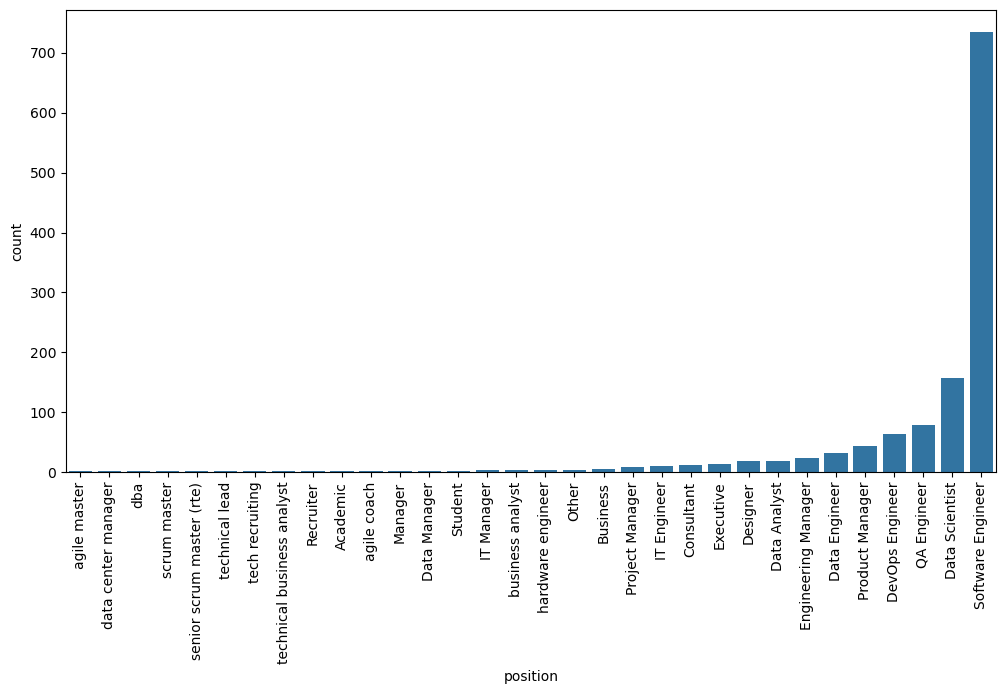

In [56]:
# Check distribution

ordered = df[column].value_counts().sort_values().index
sns.countplot(df, x=column, order=ordered)
plt.xticks(rotation=90);

###  **'Total years of experience'**
- **Inconsistencies:**
    - null values
    - extreme outlier
    - positive skew
    - spikes every 5 year mark (assume rounding)
    - values less than 'years of experience in germany'
- **Actions taken:**
    - convert/replace extreme outlier (383 assumed to be months)
    - impute null values using KNN
    - log transformation
    - standardize column (StandardScaler) or bin values?
    - for values less than 'years of experience in germany', swap values

In [57]:
# Basic EDA

column = 'total years of experience'
tb.eda_column_summary(df, column)

=== COLUMN: total years of experience ===

DTYPE:
float64

NON-NULL VALUES:
1,230

NULL VALUES:
19

UNIQUE VALUES:
42

BASIC STATS:
count   1,230.00
mean        9.08
std        11.90
min         0.00
25%         5.00
50%         8.00
75%        12.00
max       383.00
Name: total years of experience, dtype: float64

TOP VALUES:
total years of experience
10.00    138
5.00     136
6.00      99
8.00      92
7.00      84
Name: count, dtype: int64

BOTTOM VALUES:
total years of experience
7.50      1
29.00     1
24.00     1
31.00     1
383.00    1
Name: count, dtype: int64


In [58]:
# Check distribution

df[column].value_counts()

total years of experience
10.00     138
5.00      136
6.00       99
8.00       92
7.00       84
4.00       80
12.00      67
3.00       66
15.00      63
9.00       60
2.00       57
11.00      43
13.00      41
14.00      39
1.00       31
20.00      28
16.00      20
18.00      16
17.00      12
25.00       7
19.00       7
0.00        6
22.00       5
2.50        4
30.00       4
21.00       3
27.00       2
3.50        2
4.50        2
23.00       2
1.50        2
0.80        2
40.00       1
26.00       1
5.50        1
28.00       1
6.50        1
7.50        1
29.00       1
24.00       1
31.00       1
383.00      1
Name: count, dtype: int64

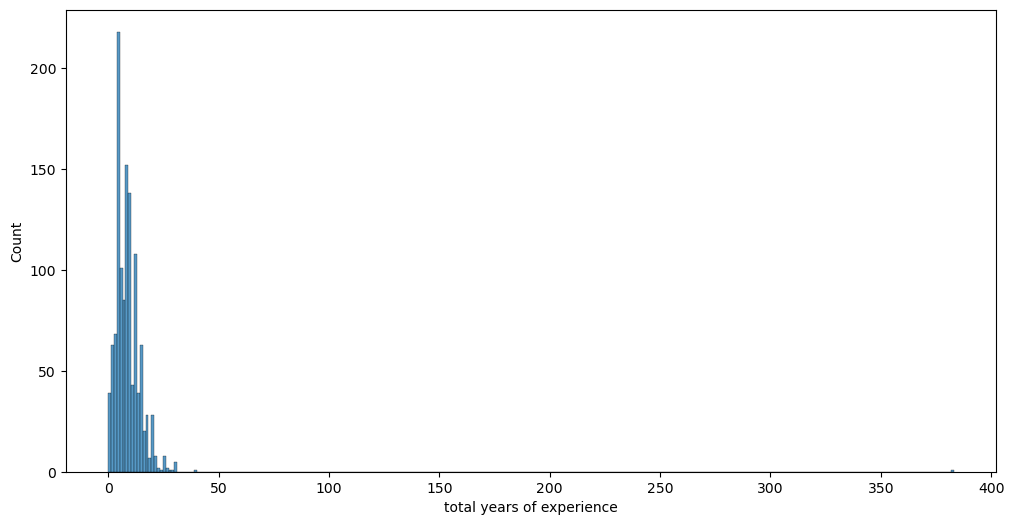

In [59]:
# Check distribution

sns.histplot(df, x=column);

In [60]:
# Look at values greater than 40

df[df[column]>40]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
1102,2020-12-06 21:51:21,69.00,male,stuttgart,Other,383.00,3.00,head,<NA>,<NA>,"70,000.00",NaN,NaN,<NA>,<NA>,german,11-50,consulting / agency,"70,000.00"


In [61]:
# Convert extreme value to months

383/12

31.916666666666668

32 years seems reasonable

In [62]:
# Replace value

df.loc[df[column]==383.00, column] = 32

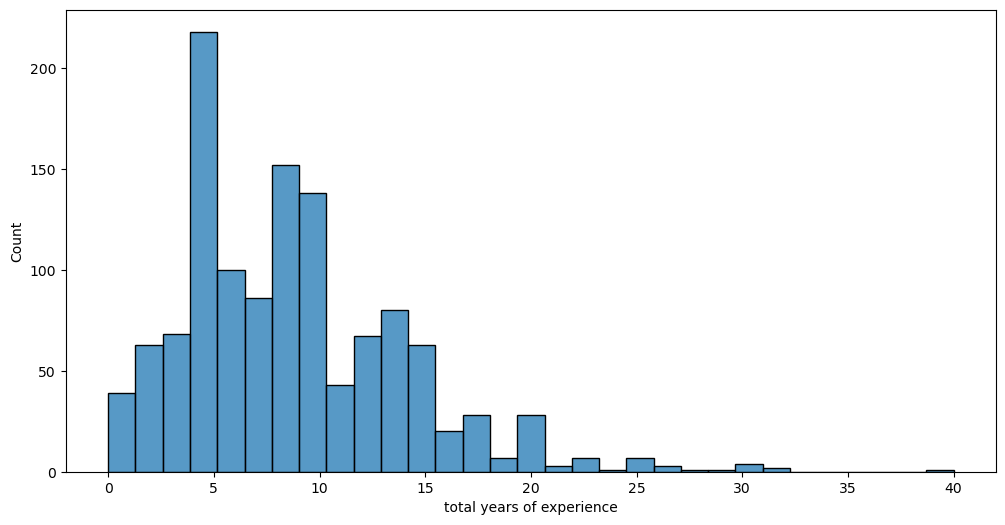

In [63]:
# Check distribution again

sns.histplot(df, x=column);

In [64]:
# Total Experience should be greater than German Experience. Check for values that are less than German Experience

mask = df['years of experience in germany'] > df[column]

df[mask]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
318,2020-11-24 17:03:03,33.00,diverse,hamburg,Software Engineer,1.00,6.00,middle,scala,"python, sql, kubernetes, docker","130,000.00",0.00,NaN,full-time employee,unlimited contract,english,1000+,product,"130,000.00"
339,2020-11-24 17:39:35,28.00,male,munich,Software Engineer,5.00,6.00,senior,c++,"python, c/c++","67,000.00","2,000.00",20.00,self-employed (freelancer),unlimited contract,english,up to 10,startup,"69,000.00"
508,2020-11-25 09:40:44,36.00,female,berlin,DevOps Engineer,1.00,3.00,middle,java,"kubernetes, docker","60,000.00","5,000.00",26.00,full-time employee,unlimited contract,english,51-100,consulting / agency,"65,000.00"
700,2020-11-25 21:05:06,43.00,male,berlin,DevOps Engineer,21.00,26.00,lead,<NA>,"python, php, sql, perl, aws, google cloud, kub...","83,000.00",NaN,28.00,full-time employee,unlimited contract,german,51-100,startup,"83,000.00"
847,2020-11-27 14:34:16,NaN,female,berlin,Data Scientist,1.00,8.00,junior,python,"python, r, sql, azure","55,000.00",NaN,30.00,full-time employee,unlimited contract,english,1000+,product,"55,000.00"
919,2020-11-30 10:48:04,28.00,male,berlin,Data Scientist,0.00,1.00,junior,python,"python, docker","48,000.00",NaN,30.00,full-time employee,unlimited contract,english,11-50,startup,"48,000.00"
961,2020-11-30 13:52:05,36.00,male,hamburg,Data Scientist,2.00,10.00,middle,python,"java / scala, sql","63,000.00",NaN,30.00,full-time employee,unlimited contract,english,11-50,product,"63,000.00"
1097,2020-12-06 14:46:17,32.00,male,berlin,Designer,5.00,10.00,senior,java,"python, php, javascript / typescript, sql","70,000.00","5,000.00",24.00,self-employed (freelancer),unlimited contract,german,up to 10,startup,"75,000.00"
1122,2020-12-08 08:17:39,27.00,male,munich,Software Engineer,2.00,5.00,junior,java,javascript / typescript,"68,000.00","2,000.00",28.00,full-time employee,unlimited contract,english,101-1000,product,"70,000.00"


Most records look like they've reversed total experience and german experience

In [65]:
# Swap total experience with german experience

df.loc[mask, [column, 'years of experience in germany']] = df.loc[mask, ['years of experience in germany', column]].values

In [66]:
# Verify number of rows dropped is correct (s/b zero)

len(df[mask])

9

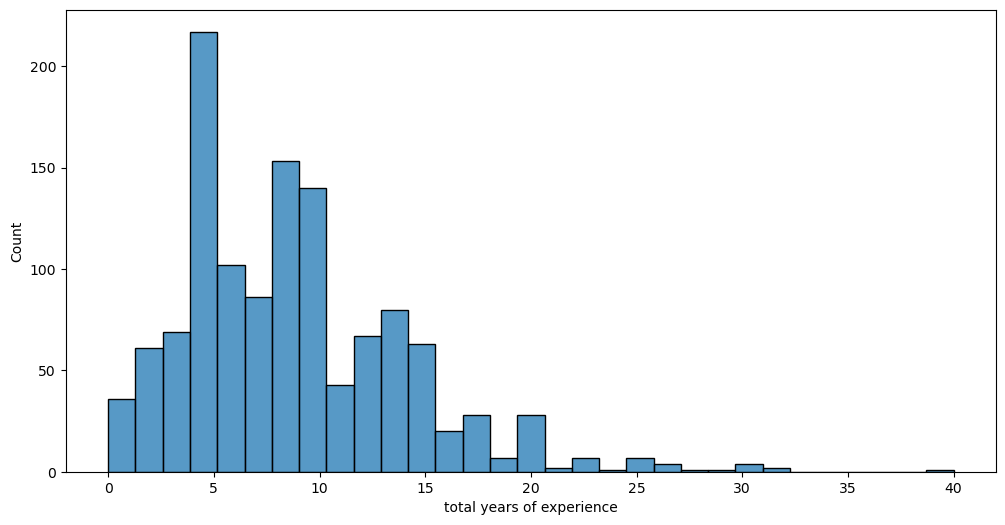

In [67]:
# Check distribution one more time

sns.histplot(df, x=column);

###  **'Years of experience in Germany'**
- **Inconsistencies:**
    - null values
    - positive skew
    - records with total experience less than german experience
- **Actions taken:**
    - impute nulls
    - log transform data
    - swap total experience with german experience (completed in total experience section)

In [68]:
# Basic EDA

column = 'years of experience in germany'
tb.eda_column_summary(df, column)

=== COLUMN: years of experience in germany ===

DTYPE:
float64

NON-NULL VALUES:
1,195

NULL VALUES:
54

UNIQUE VALUES:
36

BASIC STATS:
count   1,195.00
mean        3.72
std         3.63
min         0.00
25%         1.00
50%         3.00
75%         5.00
max        30.00
Name: years of experience in germany, dtype: float64

TOP VALUES:
years of experience in germany
2.00    197
1.00    191
3.00    154
5.00    143
4.00    122
Name: count, dtype: int64

BOTTOM VALUES:
years of experience in germany
21.00    1
4.50     1
0.10     1
2.60     1
0.20     1
Name: count, dtype: int64


In [69]:
# Check distribution

df[column].value_counts()


years of experience in germany
2.00     197
1.00     191
3.00     154
5.00     143
4.00     122
0.00     101
6.00      68
7.00      37
10.00     27
1.50      24
9.00      20
8.00      16
0.50      13
12.00     12
2.50      10
3.50       9
15.00      8
20.00      7
11.00      7
14.00      5
13.00      4
30.00      3
0.25       2
18.00      2
19.00      2
0.40       1
0.90       1
0.80       1
25.00      1
16.00      1
17.00      1
21.00      1
4.50       1
0.10       1
2.60       1
0.20       1
Name: count, dtype: int64

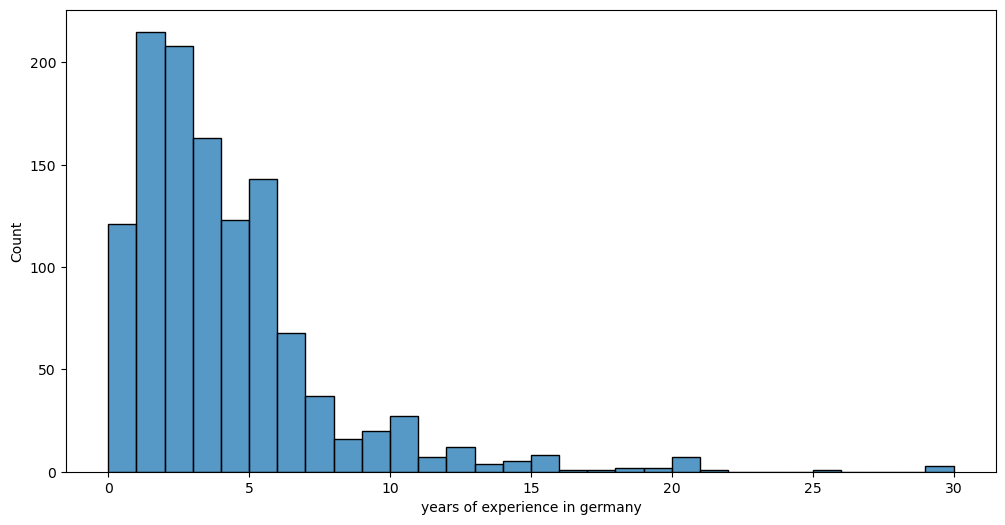

In [70]:
# Check distribution

sns.histplot(df, x=column, bins=30);

In [71]:
# There sure are a lot of zeros...

df[df[column]==0].sample(10)

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation
1061,2020-12-02 19:35:54,27.00,male,hamburg,Software Engineer,0.00,0.00,junior,python,javascript / typescript,"50,000.00","5,000.00",30.00,full-time employee,unlimited contract,english,up to 10,startup,"55,000.00"
937,2020-11-30 11:52:06,45.00,male,madrid,Data Scientist,2.00,0.00,senior,python,"sql, azure","42,000.00",NaN,NaN,full-time employee,unlimited contract,spanish,101-1000,consulting / agency,"42,000.00"
913,2020-11-29 20:04:23,34.00,male,moscow,Software Engineer,14.00,0.00,lead,haskell,"python, c/c++, .net, sql","100,000.00",0.00,30.00,full-time employee,temporary contract,english,51-100,product,"100,000.00"
732,2020-11-26 08:37:49,27.00,male,munich,Data Engineer,2.00,0.00,junior,python,"python, sql, aws, azure, docker","49,000.00","5,000.00",30.00,full-time employee,unlimited contract,german,11-50,consulting / agency,"54,000.00"
1150,2020-12-12 20:52:06,26.00,male,stockholm,Data Scientist,2.50,0.00,middle,python/nlp,"python, aws, google cloud, kubernetes, docker","60,000.00","60,000.00",30.00,full-time employee,unlimited contract,english,1000+,product,"120,000.00"
972,2020-11-30 16:01:37,23.00,male,newark,Student,4.00,0.00,entry level,"django, flask, plotly dash","python, aws","54,179.13","60,847.32",NaN,"full-time position, part-time position, & self...",unlimited contract,english,up to 10,"full-time position in education, part-time pos...","115,026.45"
415,2020-11-24 20:23:56,30.00,male,kyiv,Software Engineer,8.00,0.00,middle,web developer,"php, javascript / typescript, sql, docker","27,000.00",0.00,21.00,full-time employee,temporary contract,pcc,51-100,product,"27,000.00"
736,2020-11-26 08:41:29,25.00,male,berlin,Software Engineer,8.00,0.00,senior,clojure,"swift, javascript / typescript, java / scala, ...","85,000.00","10,000.00",24.00,full-time employee,unlimited contract,english,51-100,startup,"95,000.00"
1025,2020-12-01 11:17:35,25.00,male,berlin,Software Engineer,6.00,0.00,middle,scala,"python, javascript / typescript, java / scala,...","65,000.00","1,000.00",30.00,full-time employee,unlimited contract,english,1000+,product,"66,000.00"
350,2020-11-24 17:55:30,22.00,male,warsaw,Software Engineer,3.00,0.00,middle,php,<NA>,"27,000.00",NaN,21.00,full-time employee,unlimited contract,polish,51-100,consulting / agency,"27,000.00"


I guess it's possible to have that many zeros... And it fits the distribution.

###  **'Seniority level'**
- **Inconsistencies:**
    - null values
    - non-standardized categories
- **Actions taken:**
    - impute null values
    - manually standardize categories
    - add rank
    - exclude this column from model, use rank instead

In [72]:
# Basic EDA

column = 'seniority level'
tb.eda_column_summary(df, column)

=== COLUMN: seniority level ===

DTYPE:
category

NON-NULL VALUES:
1,241

NULL VALUES:
8

UNIQUE VALUES:
21

BASIC STATS:
count       1241
unique        21
top       senior
freq         565
Name: seniority level, dtype: object

TOP VALUES:
seniority level
senior    565
middle    366
lead      166
junior     79
head       44
Name: count, dtype: int64

BOTTOM VALUES:
seniority level
manager                1
self employed          1
vp                     1
work center manager    1
working student        1
Name: count, dtype: int64


In [73]:
df[column].unique().tolist()

['senior',
 'lead',
 'junior',
 'middle',
 'head',
 <NA>,
 'no level',
 'vp',
 'manager',
 'work center manager',
 'cto',
 'director',
 'key',
 'c-level executive manager',
 'principal',
 'intern',
 'student',
 'no idea, there are no ranges in the firm',
 'c-level',
 'working student',
 'entry level',
 'self employed']

In [74]:
# Convert dtype to string

df[column] = df[column].astype("string")

In [75]:
# Standardize categories

df[column] = df[column].replace({
    'senior': 'SENIOR',
    'lead': 'MANAGER',
    'junior': 'JUNIOR',
    'middle': 'MID',
    'head': 'DIRECTOR',
    None: 'NO_LEVEL',
    'no level': 'NO_LEVEL',
    'vp': 'EXECUTIVE',
    'manager': 'MANAGER',
    'work center manager': 'MANAGER',
    'cto': 'EXECUTIVE',
    'director': 'DIRECTOR',
    'key': 'MANAGER',
    'c-level executive manager': 'EXECUTIVE',
    'principal': 'MANAGER',
    'intern': 'JUNIOR',
    'student': 'JUNIOR',
    'no idea, there are no ranges in the firm': 'NO_LEVEL',
    'c-level': 'EXECUTIVE',
    'working student': 'JUNIOR',
    'entry level': 'JUNIOR',
    'self employed': 'SELF_EMPLOYED'
}).fillna('NO_LEVEL')

In [76]:
# Convert dtype back to category

df[column] = df[column].astype("category")
df[column].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1249 entries, 0 to 1248
Series name: seniority level
Non-Null Count  Dtype   
--------------  -----   
1249 non-null   category
dtypes: category(1)
memory usage: 1.7 KB


In [77]:
df[column].value_counts()

seniority level
SENIOR           565
MID              366
MANAGER          172
JUNIOR            85
DIRECTOR          45
NO_LEVEL          11
EXECUTIVE          4
SELF_EMPLOYED      1
Name: count, dtype: int64

In [78]:
# Create ranking map for standardized categories and add column

seniority_rank = {
    'NO_LEVEL': 0,
    'JUNIOR': 1,
    'MID': 2,
    'SENIOR': 3,
    'MANAGER': 4,
    'DIRECTOR': 5,
    'EXECUTIVE': 6,
    'SELF_EMPLOYED': 7
}

df['seniority rank'] = df[column].map(seniority_rank).astype(int)
df.head(3)

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation,seniority rank
0,2020-11-24 11:14:15,26.00,male,munich,Software Engineer,5.00,3.00,SENIOR,typescript,"kotlin, javascript / typescript","80,000.00","5,000.00",30.00,full-time employee,unlimited contract,english,51-100,product,"85,000.00",3
1,2020-11-24 11:14:16,26.00,male,berlin,Software Engineer,7.00,4.00,SENIOR,ruby,<NA>,"80,000.00",NaN,28.00,full-time employee,unlimited contract,english,101-1000,product,"80,000.00",3
2,2020-11-24 11:14:21,29.00,male,berlin,Software Engineer,12.00,6.00,MANAGER,javascript / typescript,"javascript / typescript, docker","120,000.00","120,000.00",30.00,self-employed (freelancer),temporary contract,english,101-1000,product,"240,000.00",4


Value counts: seniority rank
3    565
2    366
4    172
1     85
5     45
0     11
6      4
7      1
Name: count, dtype: int64


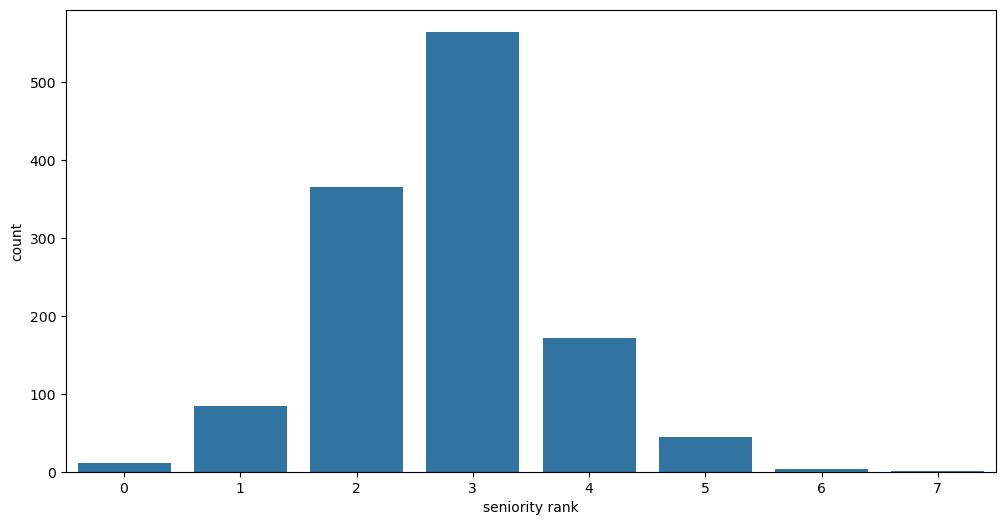

In [79]:
# Check distribution

sns.countplot(df, x='seniority rank');

print(f"Value counts: {df['seniority rank'].value_counts()}")


###  **'Your main technology / programming language'** 
- **Inconsistencies:**
    - null values
    - non-standardized categories
    - multiple values per record
    - different spellings
- **Actions taken:**
    - impute nulls
    - standardize with Word2Vec?

In [80]:
# Basic EDA

column = 'your main technology / programming language'

tb.eda_column_summary(df, column)

=== COLUMN: your main technology / programming language ===

DTYPE:
category

NON-NULL VALUES:
1,125

NULL VALUES:
124

UNIQUE VALUES:
206

BASIC STATS:
count       1125
unique       206
top       python
freq         212
Name: your main technology / programming language, dtype: object

TOP VALUES:
your main technology / programming language
python        212
java          196
javascript     80
php            71
c++            41
Name: count, dtype: int64

BOTTOM VALUES:
your main technology / programming language
typescript/angular    1
vb, rpa, python       1
vhdl                  1
web                   1
web developer         1
Name: count, dtype: int64


In [81]:
# Create temp df for tech skills

main_skills = 'your main technology / programming language'
other_skills = 'other technologies/programming languages you use often'

# Create df
df_skills = df[[main_skills, other_skills]].copy()

# Preserve index
df_skills['orig_index'] = df.index

# Combine skills into one column
df_skills['all_skills'] = df[[main_skills, other_skills]].apply(lambda row: [s for s in row if pd.notna(s)], axis=1)
df_skills.head()

Column,your main technology / programming language,other technologies/programming languages you use often,orig_index,all_skills
0,typescript,"kotlin, javascript / typescript",0,"[typescript, kotlin, javascript / typescript]"
1,ruby,<NA>,1,[ruby]
2,javascript / typescript,"javascript / typescript, docker",2,"[javascript / typescript, javascript / typescr..."
3,javascript,<NA>,3,[javascript]
4,c# .net,".net, sql, aws, docker",4,"[c# .net, .net, sql, aws, docker]"


In [82]:
# Clean and split skills

import re

def clean_skill_list(skill_list):
    cleaned = []
    for s in skill_list:
        if not isinstance(s, str):
            continue

        # Normalize separators
        s = s.replace('/', ',').replace(';', ',').replace('&', ',')
        s = s.replace('+', ',')  # python + sql
        s = s.strip()

        # Special cases you mentioned
        if s == 'aws hadoop postgre typescript':
            cleaned.extend(['aws', 'hadoop', 'postgre', 'typescript'])
            continue
        if s == 'c# .net':
            cleaned.extend(['c#', '.net'])
            continue
        if s == ' ms sql stack':
            cleaned.extend(['ms', 'sql', 'stack'])
            continue

        # Split on commas after normalization
        parts = [p.strip() for p in s.split(',') if p.strip()]

        cleaned.extend(parts)

    return cleaned

In [83]:
# Apply the cleaning function

df_skills['all_skills'] = df_skills['all_skills'].apply(clean_skill_list)

In [84]:
# Explode the all skills column

df_exploded = df_skills.explode('all_skills').reset_index(drop=True)

In [85]:
# Clean typos and spelling errors

from rapidfuzz import process

def correct_to_known(skill, known_list, threshold=70):
    if not isinstance(skill, str):
        return skill
    match, score, _ = process.extractOne(skill, known_list)
    return match if score >= threshold else skill

In [86]:
# Get list of unique values

unique_skills_list = sorted(df_exploded['all_skills'].dropna().unique().tolist())

In [87]:
# Apply spell correct function

df_exploded['clean_skills'] = df_exploded['all_skills'].apply(
    lambda s: correct_to_known(s, known_list=unique_skills_list)
)

In [88]:
# Remove white spaces again

df_exploded['clean_skills'] = df_exploded['clean_skills'].str.strip()

In [89]:
# Update list of unique values

unique_skills_list = sorted(df_exploded['all_skills'].dropna().unique().tolist())
#unique_skills_list

In [90]:
# Create a mapping dictionary to standardize tech and programming skills (credit goes to copilot)

skill_mapping = {

    # --- Programming Languages ---
    'c': 'c',
    'c#': 'c#',
    'c++': 'c++',
    'java': 'java',
    'java backend': 'java',
    'javascript': 'javascript',
    'js': 'javascript',
    'react js': 'react',
    'react.js': 'react',
    'reactjs': 'react',
    'javscript': 'javascript',
    'typescript': 'typescript',
    'ts': 'typescript',
    'python': 'python',
    'pyrhon': 'python',
    'pythin': 'python',
    'r': 'r',
    'ruby': 'ruby',
    'ruby on rails': 'ruby on rails',
    'go': 'go',
    'golang': 'go',
    'rust': 'rust',
    'scala': 'scala',
    'haskell': 'haskell',
    'clojure': 'clojure',
    'dart': 'dart',
    'objective c': 'objective-c',
    'objective-c': 'objective-c',
    'perl': 'perl',
    'php': 'php',
    'vb': 'vb',
    'vb.net': 'vb.net',
    'vba': 'vba',
    'pascal': 'pascal',
    'assembly': 'assembly',
    'julia': 'julia',
    'qml': 'qml',
    'qt': 'qt',

    # --- Web / Frontend ---
    'html': 'html',
    'css': 'css',
    'css3': 'css',
    'react': 'react',
    'angular': 'angular',
    'angular2': 'angular',
    'frontend': 'frontend',
    'frontend: react': 'react',
    'tailwindcss': 'tailwindcss',

    # --- Mobile ---
    'android': 'android',
    'ios': 'ios',
    'flutter': 'flutter',
    'kotlin': 'kotlin',
    'swift': 'swift',

    # --- Cloud ---
    'aws': 'aws',
    'azure': 'azure',
    'gcp': 'gcp',
    'google cloud': 'gcp',
    'google cloud platform': 'gcp',
    'cloud': 'cloud',
    'cloud computing': 'cloud',
    'clouds': 'cloud',

    # --- DevOps / Infra / CI/CD ---
    'docker': 'docker',
    'kubernetes': 'kubernetes',
    'kuberenetes': 'kubernetes',
    'kubrrnetes': 'kubernetes',
    'k8s': 'kubernetes',
    'helm': 'helm',
    'terraform': 'terraform',
    'ansible': 'ansible',
    'jenkins': 'jenkins',
    'jenkins bash': 'jenkins',
    'puppet': 'puppet',
    'nomad': 'nomad',
    'packer': 'packer',
    'openstack': 'openstack',
    'sre': 'sre',

    # --- Data / ETL / Big Data ---
    'sql': 'sql',
    't-sql': 'sql',
    'postgres': 'postgresql',
    'postgresql': 'postgresql',
    'postgre': 'postgresql',
    'mysql': 'mysql',
    'mongodb': 'mongodb',
    'mongo': 'mongodb',
    'hadoop': 'hadoop',
    'apache hadoop': 'hadoop',
    'apache hive': 'hive',
    'hadoop hive': 'hive',
    'apache impala': 'impala',
    'apache spark': 'spark',
    'spark': 'spark',
    'scala spark': 'spark',
    'etl': 'etl',
    'elt': 'etl',
    'informatica powercenter': 'informatica',
    'dwh': 'dwh',
    'bq': 'bigquery',

    # --- ML / AI / Data Science ---
    'ml': 'ml',
    'ai': 'ai',
    'pytorch': 'pytorch',
    'tensorflow': 'tensorflow',
    'theano': 'theano',
    'nlp': 'nlp',
    'statistics': 'statistics',
    'plotly dash': 'plotly-dash',

    # --- BI / Analytics ---
    'power bi': 'powerbi',
    'qlik': 'qlik',
    'qlik bi tool': 'qlik',
    'qliksense': 'qliksense',
    'tableau': 'tableau',
    'bi': 'bi',

    # --- Scripting / Shell / OS ---
    'bash': 'bash',
    'shell': 'shell',
    '*shell(s) scripts': 'shell',
    'unix shell scripts': 'shell',
    'unix': 'unix',
    'linux': 'linux',
    'linux kernel': 'linux',
    'powershell': 'powershell',

    # --- Frameworks / Backend ---
    'django': 'django',
    'flask': 'flask',
    'spring': 'spring',
    'grails': 'grails',
    'graphql': 'graphql',
    'groovy': 'groovy',

    # --- Embedded / Hardware ---
    'embedded': 'embedded',
    'embeddded': 'embedded',
    'embedded c': 'embedded c',
    'hardware': 'hardware',
    'vhdl': 'vhdl',

    # --- Tools / Platforms ---
    'git': 'git',
    'jira': 'jira',
    'atlassian jira': 'jira',
    'figma': 'figma',
    'sketch': 'sketch',
    'magento': 'magento',
    'sap': 'sap',
    'sap abap': 'abap',
    'sap bw': 'sap bw',
    'salesforce': 'salesforce',

    # --- Remove / Not Tech / Noise ---
    '-': None,
    '--': None,
    'etc...': None,
    'nothing': None,
    'o': None,
    'ga': None,
    'gtm': None,
    'consumer analysis': None,
    'business development manager operation': None,
    'management': None,
    'network': None,
    'networking': None,
    'network security': None,
    'network automation': None,
    'web': None,
    'web apps': None,
    'web developer': None,
    'automation': None,
    'test management': None,
    'pm tools': None,
    'qa': None,
    'spss': None,
    'uml': None,
    'virtualisation platforms': None,
    'vms': None,
    'whole apache data science stack': None,
    'dc management': None,
    'data center': None,
    'computer networking': None,
    'distributed systems stuff': None,
    'charles': None,
    'photoshop': None,
    'adobe xd': None,
    'adobe cloud': None,
    '3ds max': None,
    'frontend': None,  # ambiguous unless paired with framework
    'frontend: react': 'react',
    'apotheker': None,
    'several': None,
}

In [91]:
# Standardize values

df_exploded['standardized_skills'] = df_exploded['clean_skills'].map(skill_mapping)

In [92]:
# Remove white spaces again

df_exploded['standardized_skills'] = df_exploded['standardized_skills'].str.strip().astype('category')

In [93]:
# Check distribution

df_exploded['standardized_skills'].value_counts()

standardized_skills
python        643
docker        526
sql           510
javascript    503
java          445
             ... 
unix            1
vb              1
vb.net          1
vba             1
vhdl            1
Name: count, Length: 100, dtype: int64

In [94]:
# Determine bottom values based on count

# Count values
counts = df_exploded['standardized_skills'].value_counts()

# Threshold
threshold = 5
keep_skills = counts[counts > threshold].index

#keep_skills

In [95]:
# Remove bottom values

df_filtered = df_exploded[df_exploded['standardized_skills'].isin(keep_skills)]

In [96]:
# Encode

skill_dummies = pd.get_dummies(df_filtered['standardized_skills'], prefix='skill')

In [97]:
# Collapse back to one row per record

encoded = pd.concat([df_filtered['orig_index'], skill_dummies], axis=1)
encoded = encoded.groupby('orig_index').max()

In [98]:
# Merge back with original df

df = df.merge(encoded, left_index=True, right_index=True, how='left')


In [99]:
df.head()

,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation,seniority rank,skill_abap,skill_ai,skill_android,skill_angular,skill_ansible,skill_assembly,skill_aws,skill_azure,skill_bash,skill_bi,skill_bigquery,skill_c,skill_c#,skill_clojure,skill_cloud,skill_css,skill_dart,skill_django,skill_docker,skill_dwh,skill_embedded,skill_embedded c,skill_etl,skill_figma,skill_flask,skill_flutter,skill_gcp,skill_git,skill_go,skill_grails,skill_graphql,skill_groovy,skill_hadoop,skill_hardware,skill_haskell,skill_helm,skill_hive,skill_html,skill_impala,skill_informatica,skill_ios,skill_java,skill_javascript,skill_jenkins,skill_jira,skill_julia,skill_kotlin,skill_kubernetes,skill_linux,skill_magento,skill_ml,skill_mongodb,skill_mysql,skill_nlp,skill_nomad,skill_objective-c,skill_openstack,skill_packer,skill_pascal,skill_perl,skill_php,skill_plotly-dash,skill_postgresql,skill_powerbi,skill_powershell,skill_puppet,skill_python,skill_pytorch,skill_qlik,skill_qliksense,skill_qml,skill_qt,skill_r,skill_react,skill_ruby,skill_ruby on rails,skill_rust,skill_salesforce,skill_sap,skill_sap bw,skill_scala,skill_shell,skill_sketch,skill_spark,skill_spring,skill_sql,skill_sre,skill_statistics,skill_swift,skill_tableau,skill_tailwindcss,skill_tensorflow,skill_terraform,skill_theano,skill_typescript,skill_unix,skill_vb,skill_vb.net,skill_vba,skill_vhdl
0,2020-11-24 11:14:15,26.00,male,munich,Software Engineer,5.00,3.00,SENIOR,typescript,"kotlin, javascript / typescript","80,000.00","5,000.00",30.00,full-time employee,unlimited contract,english,51-100,product,"85,000.00",3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,2020-11-24 11:14:16,26.00,male,berlin,Software Engineer,7.00,4.00,SENIOR,ruby,<NA>,"80,000.00",NaN,28.00,full-time employee,unlimited contract,english,101-1000,product,"80,000.00",3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2020-11-24 11:14:21,29.00,male,berlin,Software Engineer,12.00,6.00,MANAGER,javascript / typescript,"javascript / typescript, docker","120,000.00","120,000.00",30.00,self-employed (freelancer),temporary contract,english,101-1000,product,"240,000.00",4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [100]:
# Plot distribution

order = df_filtered['standardized_skills'].dropna().value_counts().index

#plt.figure(figsize=(12, 25))
#sns.countplot(data=df_filtered['standardized_skills'].dropna(), order=order);

I spent wwwaaaaaaaaayyyyyyy too much time doing that...

###  **'Other technologies/programming languages you use often'**
- **Inconsistencies:**
    - see 'your main technology / programming language'
- **Actions taken:**
    - processed with 'your main technology / programming language'

In [101]:
# Basic EDA

column = 'other technologies/programming languages you use often'
tb.eda_column_summary(df, column)


=== COLUMN: other technologies/programming languages you use often ===

DTYPE:
category

NON-NULL VALUES:
1,096

NULL VALUES:
153

UNIQUE VALUES:
561

BASIC STATS:
count                        1096
unique                        561
top       javascript / typescript
freq                           44
Name: other technologies/programming languages you use often, dtype: object

TOP VALUES:
other technologies/programming languages you use often
javascript / typescript    44
python                     37
sql                        31
aws, docker                16
kotlin                     15
Name: count, dtype: int64

BOTTOM VALUES:
other technologies/programming languages you use often
java / scala, sql, aws, google cloud, azure, docker    1
aws, kubernetes                                        1
aws, google cloud, kubernetes, docker                  1
aws, google cloud, azure, docker                       1
.net, azure                                            1
Name: count, dtype: int6

###  **'Yearly brutto salary (without bonus and stocks) in EUR'**
- **Inconsistencies:**
    - extreme outliers
    - positive skew
    - outlier with unrealistic values in both salary and bonus column
- **Actions taken:**
    - drop record with bad salary & bonus data
    - log transformation

In [102]:
# Basic EDA

column = 'yearly brutto salary (without bonus and stocks) in eur'

tb.eda_column_summary(df, column)

=== COLUMN: yearly brutto salary (without bonus and stocks) in eur ===

DTYPE:
float64

NON-NULL VALUES:
1,249

NULL VALUES:
0

UNIQUE VALUES:
199

BASIC STATS:
count         1,249.00
mean        471,920.93
std      14,145,806.30
min          10,001.00
25%          58,800.00
50%          70,000.00
75%          80,000.00
max     500,000,000.00
Name: yearly brutto salary (without bonus and stocks) in eur, dtype: float64

TOP VALUES:
yearly brutto salary (without bonus and stocks) in eur
60,000.00    85
70,000.00    82
65,000.00    77
75,000.00    73
80,000.00    66
Name: count, dtype: int64

BOTTOM VALUES:
yearly brutto salary (without bonus and stocks) in eur
68,250.00     1
84,700.00     1
50,500.00     1
108,500.00    1
38,350.00     1
Name: count, dtype: int64


In [103]:
# Look at top salaries

df.nlargest(5, column)

,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation,seniority rank,skill_abap,skill_ai,skill_android,skill_angular,skill_ansible,skill_assembly,skill_aws,skill_azure,skill_bash,skill_bi,skill_bigquery,skill_c,skill_c#,skill_clojure,skill_cloud,skill_css,skill_dart,skill_django,skill_docker,skill_dwh,skill_embedded,skill_embedded c,skill_etl,skill_figma,skill_flask,skill_flutter,skill_gcp,skill_git,skill_go,skill_grails,skill_graphql,skill_groovy,skill_hadoop,skill_hardware,skill_haskell,skill_helm,skill_hive,skill_html,skill_impala,skill_informatica,skill_ios,skill_java,skill_javascript,skill_jenkins,skill_jira,skill_julia,skill_kotlin,skill_kubernetes,skill_linux,skill_magento,skill_ml,skill_mongodb,skill_mysql,skill_nlp,skill_nomad,skill_objective-c,skill_openstack,skill_packer,skill_pascal,skill_perl,skill_php,skill_plotly-dash,skill_postgresql,skill_powerbi,skill_powershell,skill_puppet,skill_python,skill_pytorch,skill_qlik,skill_qliksense,skill_qml,skill_qt,skill_r,skill_react,skill_ruby,skill_ruby on rails,skill_rust,skill_salesforce,skill_sap,skill_sap bw,skill_scala,skill_shell,skill_sketch,skill_spark,skill_spring,skill_sql,skill_sre,skill_statistics,skill_swift,skill_tableau,skill_tailwindcss,skill_tensorflow,skill_terraform,skill_theano,skill_typescript,skill_unix,skill_vb,skill_vb.net,skill_vba,skill_vhdl
852,2020-11-27 14:55:13,29.00,female,cologne,Data Scientist,1.00,1.00,MID,julia,<NA>,"500,000,000.00","5,000,000,000.00",99.00,full-time employee,unlimited contract,english,up to 10,startup,"5,500,000,000.00",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,2020-11-26 17:08:47,42.00,male,berlin,Software Engineer,18.00,5.00,SENIOR,react js,javascript / typescript,"850,000.00","95,000.00",35.00,full-time employee,unlimited contract,english,101-1000,product,"945,000.00",3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
575,2020-11-25 13:26:21,24.00,male,munich,Data Scientist,1.00,1.00,JUNIOR,c++,"python, c/c++, swift, java / scala, r, sql, go...","300,000.00",NaN,NaN,full-time employee,<NA>,english,101-1000,startup,"300,000.00",1,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
629,2020-11-25 15:53:21,40.00,male,cupertino,Software Engineer,2

- index 852: DROP - salary & bonus not usable, errors in other fields
- index 575: looks kinda sus but keep

In [104]:
# Drop index #852

df = df.drop(852).reset_index(drop=True)

In [105]:
# Verify number of rows dropped is correct

df_length_3 = len(df)

df_length_2 - df_length_3


1

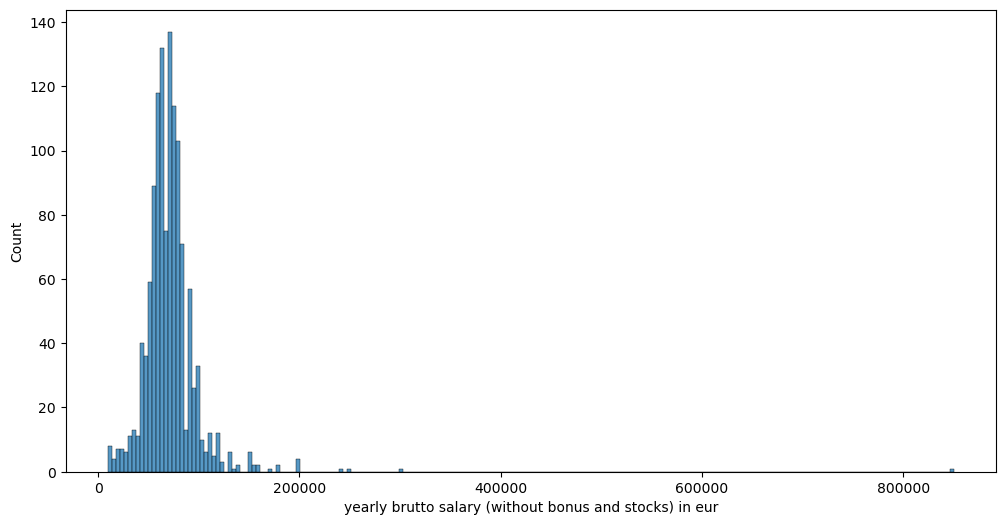

In [106]:
# Check distribution

sns.histplot(df, x=column);


###  **'Yearly bonus + stocks in EUR'**
- **Inconsistencies:**
    - lots of null values
    - zero values (but those might make sense)
    - extreme outliers
- **Actions taken:**
    - replace null values with zero
    - replace top value with null as it doesn't seem reasonable given salary and position
    - log transformation

In [107]:
# Basic EDA

column = 'yearly bonus + stocks in eur'

tb.eda_column_summary(df, column)

=== COLUMN: yearly bonus + stocks in eur ===

DTYPE:
float64

NON-NULL VALUES:
822

NULL VALUES:
426

UNIQUE VALUES:
161

BASIC STATS:
count         822.00
mean       21,562.53
std        53,542.43
min             0.00
25%             0.00
50%         5,000.00
75%        20,000.00
max     1,150,000.00
Name: yearly bonus + stocks in eur, dtype: float64

TOP VALUES:
yearly bonus + stocks in eur
0.00         227
5,000.00      56
10,000.00     45
2,000.00      36
6,000.00      26
Name: count, dtype: int64

BOTTOM VALUES:
yearly bonus + stocks in eur
110,000.00    1
700.00        1
16,320.00     1
105,000.00    1
40,950.00     1
Name: count, dtype: int64


In [108]:
# Look at top salaries

df.nlargest(5, column)

,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation,seniority rank,skill_abap,skill_ai,skill_android,skill_angular,skill_ansible,skill_assembly,skill_aws,skill_azure,skill_bash,skill_bi,skill_bigquery,skill_c,skill_c#,skill_clojure,skill_cloud,skill_css,skill_dart,skill_django,skill_docker,skill_dwh,skill_embedded,skill_embedded c,skill_etl,skill_figma,skill_flask,skill_flutter,skill_gcp,skill_git,skill_go,skill_grails,skill_graphql,skill_groovy,skill_hadoop,skill_hardware,skill_haskell,skill_helm,skill_hive,skill_html,skill_impala,skill_informatica,skill_ios,skill_java,skill_javascript,skill_jenkins,skill_jira,skill_julia,skill_kotlin,skill_kubernetes,skill_linux,skill_magento,skill_ml,skill_mongodb,skill_mysql,skill_nlp,skill_nomad,skill_objective-c,skill_openstack,skill_packer,skill_pascal,skill_perl,skill_php,skill_plotly-dash,skill_postgresql,skill_powerbi,skill_powershell,skill_puppet,skill_python,skill_pytorch,skill_qlik,skill_qliksense,skill_qml,skill_qt,skill_r,skill_react,skill_ruby,skill_ruby on rails,skill_rust,skill_salesforce,skill_sap,skill_sap bw,skill_scala,skill_shell,skill_sketch,skill_spark,skill_spring,skill_sql,skill_sre,skill_statistics,skill_swift,skill_tableau,skill_tailwindcss,skill_tensorflow,skill_terraform,skill_theano,skill_typescript,skill_unix,skill_vb,skill_vb.net,skill_vba,skill_vhdl
563,2020-11-25 12:27:53,30.00,male,berlin,Data Engineer,5.00,4.00,MANAGER,<NA>,python,"90,000.00","1,150,000.00",26.00,full-time employee,unlimited contract,english,1000+,product,"1,240,000.00",4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
629,2020-11-25 15:53:21,40.00,male,cupertino,Software Engineer,20.00,0.00,MANAGER,swift,<NA>,"250,000.00","450,000.00",45.00,full-time employee,unlimited contract,english,1000+,product,"700,000.00",4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
279,2020-11-24 15:05:21,39.00,male,berlin,Product Manager,10.00,5.00,MANAGER,<NA>,<NA>,"120,000.00","200,000.00",25.00,full-time employee,unlimited contract,english,1000+,product,"320,000.00",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,2020-11-24 21:36:24,32.00,male,berlin,Executive,10.00,4.00,EXECUTIVE,java,"python, c/c++","200,000.00"

- not unreasonable for bonuses & stocks to be greater than salary
- index 563 looks like an error - REPLACE with null

In [109]:
# Replace value for index #563  with null

df[column] = df[column].replace(1150000, pd.NA)

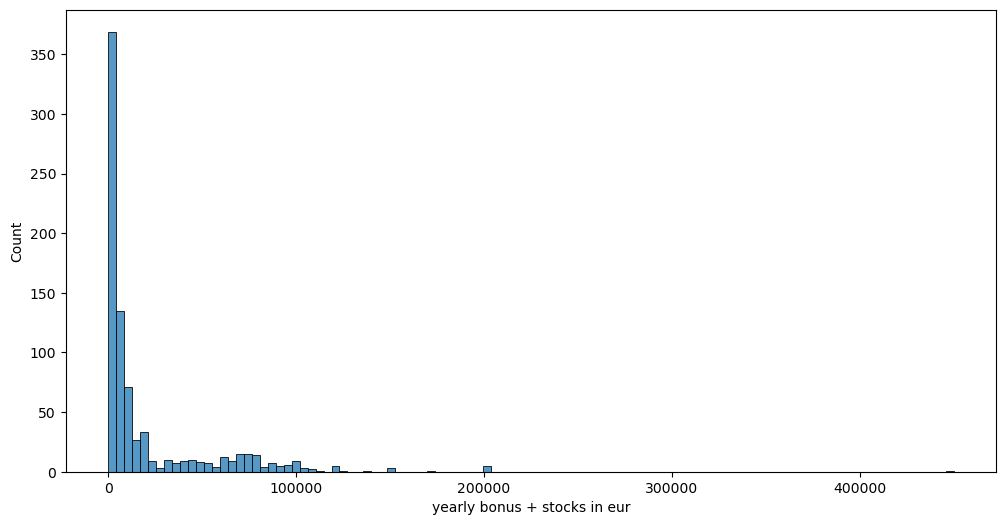

In [110]:
# Check distribution

sns.histplot(df[column].dropna());

In [111]:
# Check zero values

df[df[column]==0].sample(5)

,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type,total_compensation,seniority rank,skill_abap,skill_ai,skill_android,skill_angular,skill_ansible,skill_assembly,skill_aws,skill_azure,skill_bash,skill_bi,skill_bigquery,skill_c,skill_c#,skill_clojure,skill_cloud,skill_css,skill_dart,skill_django,skill_docker,skill_dwh,skill_embedded,skill_embedded c,skill_etl,skill_figma,skill_flask,skill_flutter,skill_gcp,skill_git,skill_go,skill_grails,skill_graphql,skill_groovy,skill_hadoop,skill_hardware,skill_haskell,skill_helm,skill_hive,skill_html,skill_impala,skill_informatica,skill_ios,skill_java,skill_javascript,skill_jenkins,skill_jira,skill_julia,skill_kotlin,skill_kubernetes,skill_linux,skill_magento,skill_ml,skill_mongodb,skill_mysql,skill_nlp,skill_nomad,skill_objective-c,skill_openstack,skill_packer,skill_pascal,skill_perl,skill_php,skill_plotly-dash,skill_postgresql,skill_powerbi,skill_powershell,skill_puppet,skill_python,skill_pytorch,skill_qlik,skill_qliksense,skill_qml,skill_qt,skill_r,skill_react,skill_ruby,skill_ruby on rails,skill_rust,skill_salesforce,skill_sap,skill_sap bw,skill_scala,skill_shell,skill_sketch,skill_spark,skill_spring,skill_sql,skill_sre,skill_statistics,skill_swift,skill_tableau,skill_tailwindcss,skill_tensorflow,skill_terraform,skill_theano,skill_typescript,skill_unix,skill_vb,skill_vb.net,skill_vba,skill_vhdl
1179,2020-12-20 10:31:17,28.00,male,sevilla,Data Engineer,4.00,0.00,MID,gcp,"python, java / scala, r, sql, google cloud","30,000.00",0.00,24.00,full-time employee,unlimited contract,spanish,51-100,consulting / agency,"30,000.00",2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1047,2020-12-02 04:49:47,28.00,male,munich,Software Engineer,8.00,1.00,SENIOR,php,"php, javascript / typescript, sql, go, aws","57,000.00",0.00,28.00,full-time employee,unlimited contract,english,51-100,product,"57,000.00",3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
570,2020-11-25 13:03:32,37.00,female,berlin,Data Scientist,2.00,2.00,MID,python,"r, sql, aws","62,000.00",0.00,30.00,full-time employee,unlimited contract,german,101-1000,publisher,"62,000.00",2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,Fa

- no bonus or stocks is probably reasonable

yearly brutto salary (without bonus and stocks) in eur
10,001.00     1
10,164.00     1
11,000.00     1
12,000.00     1
14,400.00     1
             ..
150,000.00    1
154,000.00    1
160,000.00    1
240,000.00    1
300,000.00    1
Name: count, Length: 100, dtype: int64


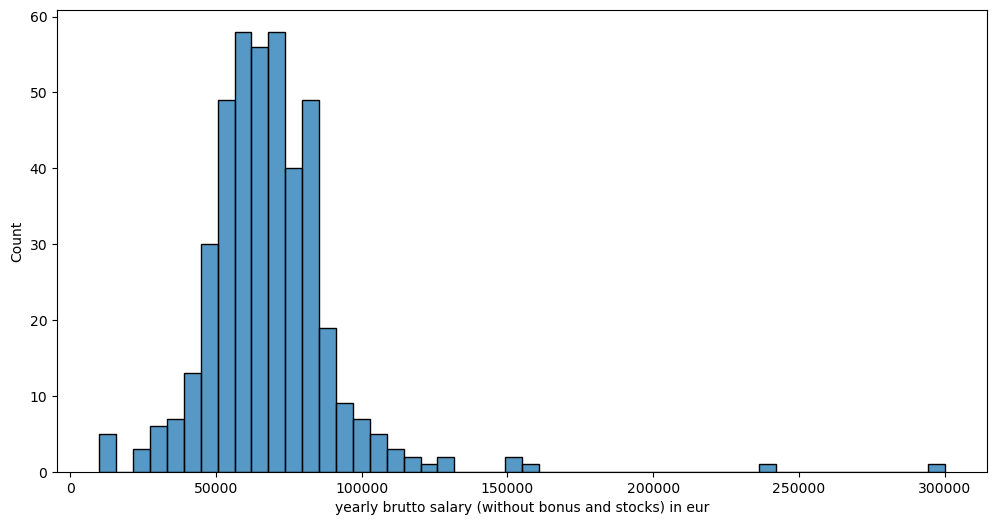

In [112]:
# Plot salary distribution of null bonuses

null_bonus = df[df[column].isna()]   #.sort_values(salary, ascending=False).head()
sns.histplot(null_bonus, x=salary);

print(null_bonus[salary].value_counts().sort_index())

seniority rank
0      6
1     30
2    126
3    203
4     51
5     10
6      1
Name: count, dtype: int64


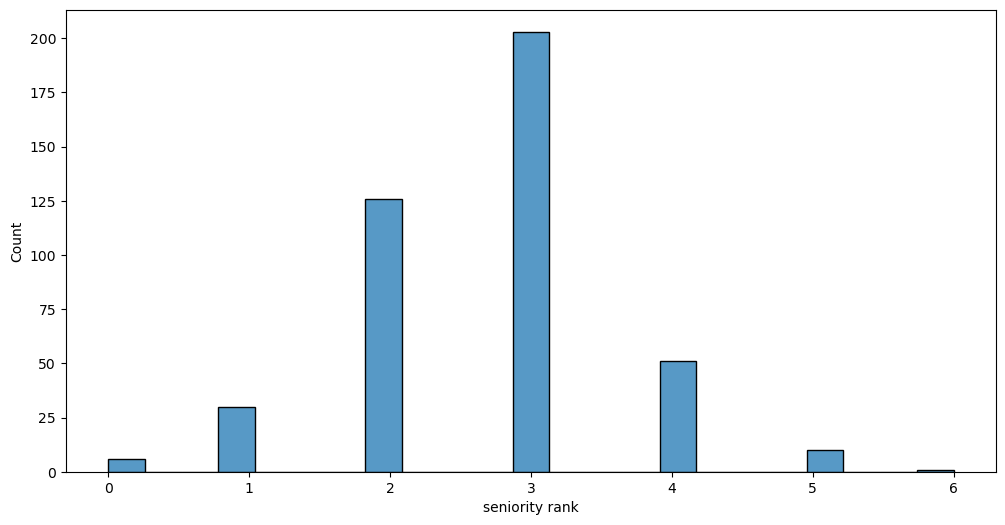

In [113]:
# Plot seniority distribution of null bonuses

null_bonus = df[df[column].isna()]   #.sort_values(salary, ascending=False).head()
sns.histplot(null_bonus, x='seniority rank');

print(null_bonus['seniority rank'].value_counts().sort_index())

###  **'Number of vacation days'**
- **Inconsistencies:**
    - null values
    - zero values (pretty sure that's illegal...)
    - values less than 20 (EU min in 20 days/4 weeks, other countries vary)
    - extreme outliers
    - positive skew? it's a weird distribution
    - spike at 30
- **Actions taken:**
    - assume values less than or equal to 10 are weeks, not days
        - multipy by 5
    - after weeks-to-days conversion, replace values still less than 20 with null
    - replace zeros with null 
    - replace >50 with null
    - impute nulls
    - log transformation?
    - standardize?

In [114]:
# Basic EDA

column = 'number of vacation days'

tb.eda_column_summary(df, column)

=== COLUMN: number of vacation days ===

DTYPE:
float64

NON-NULL VALUES:
1,171

NULL VALUES:
77

UNIQUE VALUES:
35

BASIC STATS:
count   1,171.00
mean       28.29
std        10.56
min         0.00
25%        27.00
50%        28.00
75%        30.00
max       365.00
Name: number of vacation days, dtype: float64

TOP VALUES:
number of vacation days
30.00    488
28.00    233
27.00    102
25.00     91
26.00     71
Name: count, dtype: int64

BOTTOM VALUES:
number of vacation days
5.00     1
37.00    1
39.00    1
34.00    1
10.00    1
Name: count, dtype: int64


In [115]:
# Check distribution

df[column].value_counts().sort_index()


number of vacation days
0.00        4
1.00        1
3.00        1
5.00        1
10.00       1
12.00       2
14.00       3
15.00       2
16.00       1
20.00      13
21.00      10
22.00       8
23.00       4
24.00      67
25.00      91
26.00      71
27.00     102
28.00     233
29.00      24
30.00     488
31.00       8
32.00       8
33.00       3
34.00       1
35.00       5
36.00       5
37.00       1
37.50       1
38.00       1
39.00       1
40.00       4
45.00       3
50.00       1
60.00       1
365.00      1
Name: count, dtype: int64

In [116]:
# Check values less than 10 days

df[df[column]<10].sort_values(by='city')[[column, 'city']]

,number of vacation days,city
573,0.00,berlin
640,0.00,berlin
969,5.00,berlin
958,1.00,frankfurt
980,0.00,istanbul
490,0.00,malta
548,3.00,munich


- All of these cities are in EU countries
- EU minimum paid vacation is 20 days/4 weeks
- Assume values 10 or less are weeks
    - multipy by 5

In [117]:
# Multipy values less than or equal to 10 by 5

df.loc[df[column] <= 0, column] = df[column] * 5

In [118]:
# Replace zero values, values greater than 50, and values less than 20 with null

df.loc[(df[column]==0) | (df[column] > 50) | (df[column] < 20), column] = pd.NA

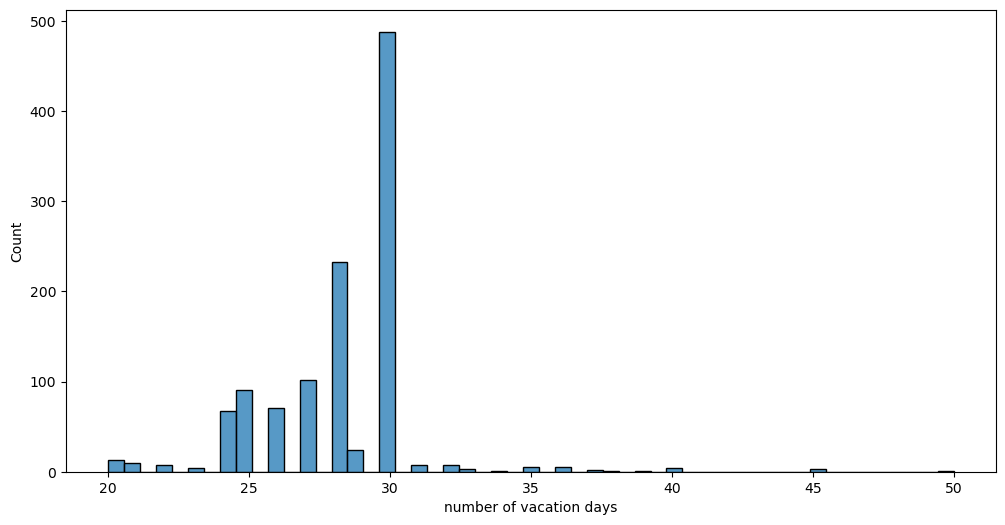

In [119]:
# Check distribution

sns.histplot(df, x=column);

- that's a weird distribution...

###  **'Employment status'**
- **Inconsistencies:**
    - null values
    - free form
    - mainly full-time
- **Actions taken:**
    - drop column - not enough variation to be meaningful

In [120]:
# Basic EDA

column = 'employment status'

tb.eda_column_summary(df, column)

=== COLUMN: employment status ===

DTYPE:
category

NON-NULL VALUES:
1,235

NULL VALUES:
13

UNIQUE VALUES:
10

BASIC STATS:
count                   1235
unique                    10
top       full-time employee
freq                    1189
Name: employment status, dtype: object

TOP VALUES:
employment status
full-time employee            1189
self-employed (freelancer)      28
part-time employee               8
founder                          3
working student                  2
Name: count, dtype: int64

BOTTOM VALUES:
employment status
company director                                                                   1
intern                                                                             1
full-time, but 32 hours per week (it was my request, i'm a student)                1
full-time position, part-time position, & self-employed (freelancing, tutoring)    1
werkstudent                                                                        1
Name: count, dtype: int64


In [121]:
# Create mapping dictionary

emp_status_map = {
'full-time employee': 'full-time',
 'self-employed (freelancer)': 'self-employed',
 'company director': 'full-time',
 'founder': 'self-employed',
 'part-time employee': 'part-time',
 'working student': 'part-time',
 'full-time position, part-time position, & self-employed (freelancing, tutoring)': 'full-time',
 'intern': 'full-time',
 "full-time, but 32 hours per week (it was my request, i'm a student)": 'full-time',
 'werkstudent': 'part-time'
}

In [122]:
# Replace values with mapping dictionary

df[column] = df[column].astype(str).replace(emp_status_map)

# Convert back to category

df[column] = df[column].astype('category')


Value counts: employment status
full-time        1193
self-employed      31
part-time          11
Name: count, dtype: int64


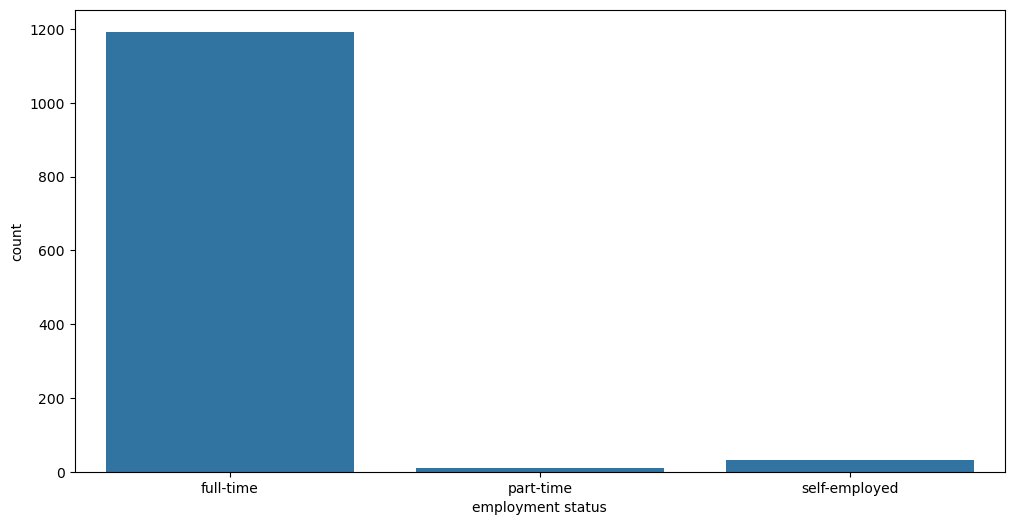

In [123]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')


###  **'Сontract duration'**
- **Inconsistencies:**
    - null values
    - zero value
- **Actions taken:**
    - replace zero with null
    - impute nulls

In [124]:
# Basic EDA

column = 'contract duration'

tb.eda_column_summary(df, column)

=== COLUMN: contract duration ===

DTYPE:
category

NON-NULL VALUES:
1,223

NULL VALUES:
25

UNIQUE VALUES:
3

BASIC STATS:
count                   1223
unique                     3
top       unlimited contract
freq                    1158
Name: contract duration, dtype: object

TOP VALUES:
contract duration
unlimited contract    1158
temporary contract      64
0                        1
Name: count, dtype: int64

BOTTOM VALUES:
contract duration
unlimited contract    1158
temporary contract      64
0                        1
Name: count, dtype: int64


In [125]:
# Check distribution

df[column].value_counts()


contract duration
unlimited contract    1158
temporary contract      64
0                        1
Name: count, dtype: int64

In [126]:
# Replace zero value

df[column] = df[column].astype(str).replace('0', pd.NA)

# Convert back to category

df[column] = df[column].astype('category')

###  **'Main language at work'**
- **Inconsistencies:**
    - null values
    - free form
    - mainly just english, some german
- **Actions taken:**
    - drop column - I don't think there is enough variation to be meaningful

In [127]:
# Basic EDA

column = 'main language at work'

tb.eda_column_summary(df, column)

=== COLUMN: main language at work ===

DTYPE:
category

NON-NULL VALUES:
1,236

NULL VALUES:
12

UNIQUE VALUES:
14

BASIC STATS:
count        1236
unique         14
top       english
freq         1019
Name: main language at work, dtype: object

TOP VALUES:
main language at work
english    1019
german      186
russian      12
spanish       3
italian       3
Name: count, dtype: int64

BOTTOM VALUES:
main language at work
50/50               1
deuglisch           1
both                1
french              1
russian, english    1
Name: count, dtype: int64


Value counts: main language at work
english               1019
german                 186
russian                 12
spanish                  3
italian                  3
czech                    2
polish                   2
pcc                      2
english and german       2
50/50                    1
deuglisch                1
both                     1
french                   1
russian, english         1
Name: count, dtype: int64


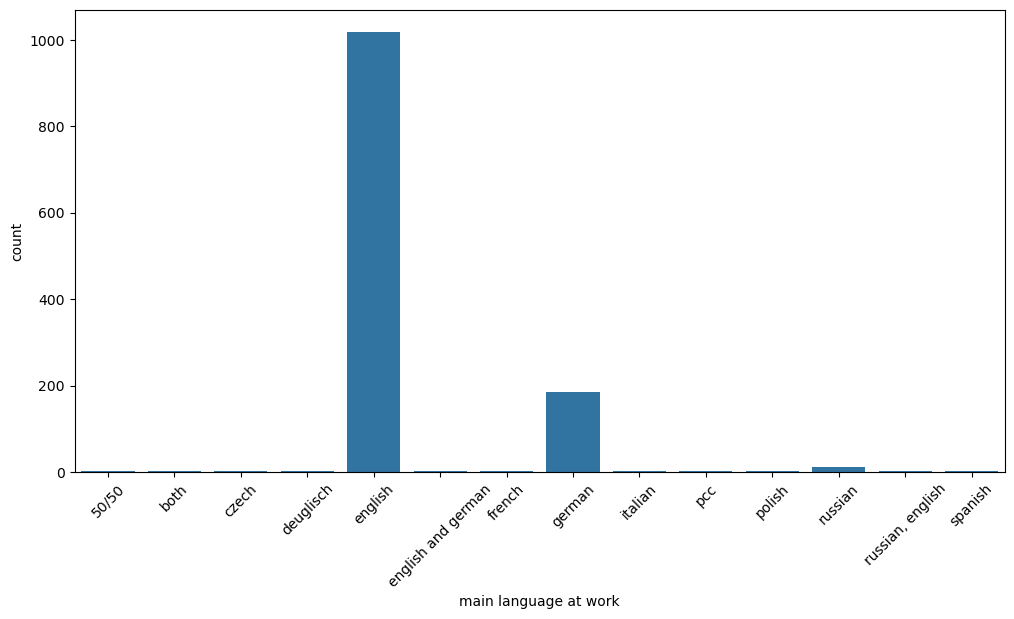

In [128]:
# Check distribution

sns.countplot(df, x=column)
plt.xticks(rotation=45);

print(f'Value counts: {df[column].value_counts()}')


###  **'Company size'**
- **Inconsistencies:**
    - null values
    - categories already binned but need rank
    - bins don't have same range - not sure if it matters...
- **Actions taken:**
    - impute null values
    - add column with rank
    - drop column from pipeline, use rank instead

In [129]:
# Basic EDA

column = 'company size'

tb.eda_column_summary(df, column)

=== COLUMN: company size ===

DTYPE:
category

NON-NULL VALUES:
1,234

NULL VALUES:
14

UNIQUE VALUES:
5

BASIC STATS:
count      1234
unique        5
top       1000+
freq        448
Name: company size, dtype: object

TOP VALUES:
company size
1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     60
Name: count, dtype: int64

BOTTOM VALUES:
company size
1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     60
Name: count, dtype: int64


In [130]:
df[column].unique().tolist()

['51-100', '101-1000', '11-50', '1000+', <NA>, 'up to 10']

In [131]:
rank_map = {
    'up to 10': 1,
    '11-50': 2,
    '51-100': 3,
    '101-1000': 4,
    '1000+': 5
}

In [132]:
df['comp_size_rank'] = df[column].map(rank_map)

Value counts: company size
1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     60
Name: count, dtype: int64


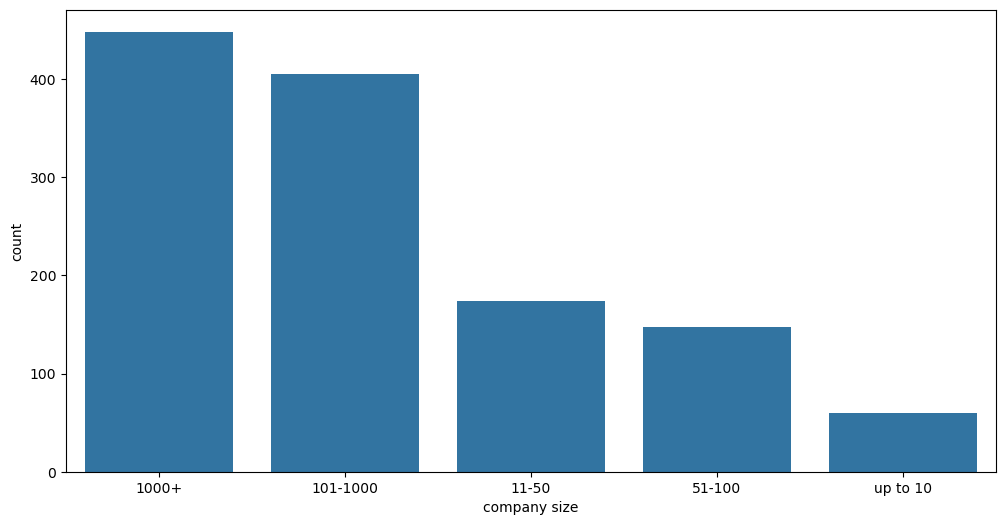

In [133]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')

###  **'Company type'**
- **Inconsistencies:**
    - null values
    - free form field
    - multiple features per record
- **Actions taken:**
    - impute nulls
    - bin categories
    

In [134]:
# Basic EDA

column = 'company type'

tb.eda_column_summary(df, column)

=== COLUMN: company type ===

DTYPE:
category

NON-NULL VALUES:
1,227

NULL VALUES:
21

UNIQUE VALUES:
57

BASIC STATS:
count        1227
unique         57
top       product
freq          760
Name: company type, dtype: object

TOP VALUES:
company type
product                760
startup                251
consulting / agency    142
bank                     6
e-commerce               5
Name: count, dtype: int64

BOTTOM VALUES:
company type
semiconductor            1
systemhaus               1
service                  1
transport & logistics    1
telecommunications       1
Name: count, dtype: int64


In [135]:
df[column].value_counts()

company type
product                                                                     760
startup                                                                     251
consulting / agency                                                         142
bank                                                                          6
e-commerce                                                                    5
corporation                                                                   3
media                                                                         3
ecommerce                                                                     2
automotive                                                                    2
utilities                                                                     2
fintech                                                                       2
university                                                                    2
research                   

In [136]:
# Create mapping dictionary to bin these

company_type_map = {
    # Product & Tech Product
    "product": "product",
    "saas": "product",
    "cloud": "product",
    "publishing and technology": "product",
    "faang": "product",
    "game company": "product",

    # Startup
    "startup": "startup",

    # Consulting / Agency / IT Services
    "consulting / agency": "consulting_it",
    "consulting and product": "consulting_it",
    "consulting": "consulting_it",
    "systemhaus": "consulting_it",
    "it-outsourcing": "consulting_it",
    "outsorce": "consulting_it",
    "outsourse": "consulting_it",
    "service": "consulting_it",
    "it department of established business": "consulting_it",

    # Everything else → other
    "university": "other",
    "education": "other",
    "science institute": "other",
    "research": "other",
    "research institute": "other",
    "institute": "other",
    "market research": "other",
    "full-time position in education, part-time position in at a data startup": "other",

    "corporation": "other",
    "enterprise": "other",
    "bloody enterprise": "other",
    "big commercial": "other",
    "concern": "other",
    "corporate incubator": "other",
    "multinational": "other",

    "bank": "other",
    "finance": "other",
    "financial": "other",
    "fintech": "other",
    "insurance": "other",

    "automotive": "other",
    "industry": "other",
    "old industry": "other",
    "semiconductor": "other",
    "construction": "other",
    "consumer goods": "other",
    "pharma": "other",
    "energy": "other",
    "utilities": "other",

    "e-commerce": "other",
    "ecommerce": "other",
    "retail": "other",
    "non-tech retail": "other",
    "handel": "other",

    "media": "other",
    "publisher": "other",

    "transport & logistics": "other",
    "telecommunications": "other",

    "behorde": "other",
    "personal ltd": "other",
    "biergarten": "other",
    "freelance": "other",
}

In [137]:
# Map the bins

df[column] = df[column].map(company_type_map)

Value counts: company type
product          765
startup          251
consulting_it    149
other             62
Name: count, dtype: Int64


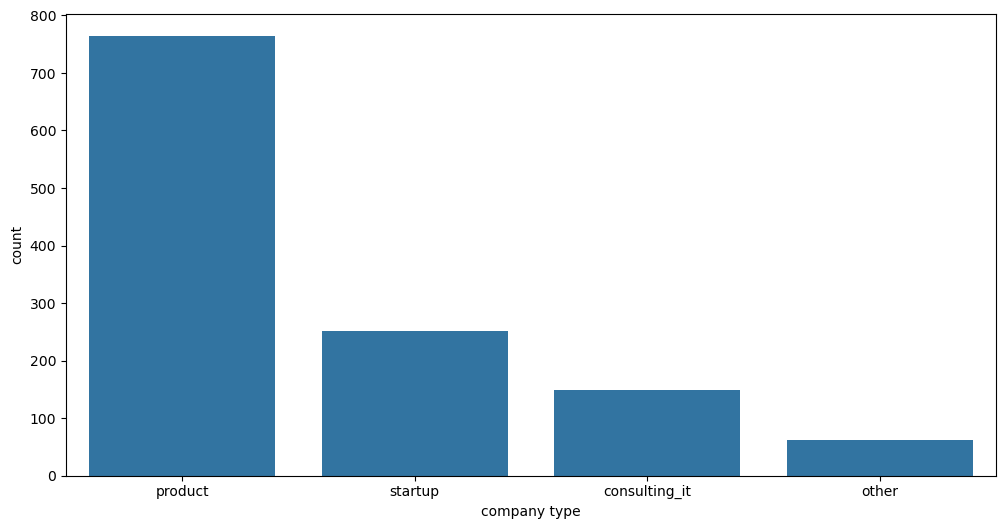

In [138]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')


## Model

In [139]:
from sklearn.base import BaseEstimator, TransformerMixin

class logTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.log1p(X)

In [140]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer                       # Applies transformations to different columns
from sklearn.impute import SimpleImputer                            # Fills in missing values
from sklearn.preprocessing import OneHotEncoder                     # Converts categorical test to numeric dummy variables
from sklearn.preprocessing import MinMaxScaler                      # Scale numeric features to [0,1]
from sklearn.model_selection import cross_val_score                 # Evaluates model with cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel



In [141]:
# Fix column type for encoded skills columns

skill_cols = [col for col in df.columns if col.startswith('skill_')]
df[skill_cols] = df[skill_cols].astype(float)

In [142]:
# Set categorical and numeric lists

df_eda = edaDF(data=df, target=target)
cat_cols = df_eda.setCatList()
num_cols = df_eda.setNumList()

drop_cols = ['timestamp',
             'other technologies/programming languages you use often',
            'employment status', 
            'gender', 
            'main language at work', 
            'number of vacation days',
            'seniority level',
            'your main technology / programming language']

cat_cols = [col for col in cat_cols if col not in drop_cols]                # Remove columns from cat & num lists if they are in drop_col list
num_cols = [col for col in num_cols if col not in drop_cols]

skill_cols = [col for col in df.columns if col.startswith('skill_')]        # Create list for encoded skills columns
num_cols = [col for col in num_cols if col not in skill_cols]               # Remove columns from num list if in skill_cols list

pos_skew_cols = ['age', 'total years of experience']                        # Create list for columns that require log transformations
norm_dist_cols = [col for col in num_cols if col not in pos_skew_cols]      # Remove columsn from num list if in pos_skew kist

cat_cols = [col for col in cat_cols if col != target]                       # Make sure target isn't in any of the lists
num_cols = [col for col in num_cols if col != target]
pos_skew_cols = [col for col in pos_skew_cols if col != target]
norm_dist_cols = [col for col in norm_dist_cols if col != target]         

# Split data into X (features) and y (target), as usual
y = df['total_compensation']
X = df.drop(columns={'total_compensation'})


## Model #1 Random Forest Regression
- logTransformer()
- SimpleImputer()
- MinMaxScaler()
- OneHotEncoder()
- SelectKBest()

In [143]:
# Model #1 Random forest

# Define log transformer for transforming positive skewed data
log_transformer = logTransformer()

pos_skew_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),                # If numeric column has missing values, replace with mean
        ("log", log_transformer),                                   # Transform positives skewed features
        ("scaler", MinMaxScaler())                                  # Rescale each numeric feature so smallest value becomes 0 and largest becomes 1
])

# Define numeric preprocessing
norm_transformer = Pipeline(steps=[                 
        ("imputer", SimpleImputer(strategy="mean")),                # If numeric column has missing values, replace with mean
        ("scaler", MinMaxScaler())                                  # Rescale each numeric feature so smallest value becomes 0 and largest becomes 1
    ])

# Define categorical preprocessing
categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])    

# Define skills preprocessing
skills_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])    

# Combine preprocessing steps with ColumnTransformer
preprocessor = ColumnTransformer(
        remainder='drop',                 
        transformers=[
        ("log_num", pos_skew_transformer, pos_skew_cols),
        ("num", norm_transformer, norm_dist_cols),              
        ("cat", categorical_transformer, cat_cols),             
        ("skills", skills_transformer, skill_cols)
    ])

# Create full pipeline 
model = RandomForestRegressor(random_state=42)                                                                            
pipe = Pipeline(steps=[
    ('pre', preprocessor),                         # Stage 1: "Pre" - run ColumnTransformer
    ('select', SelectKBest(score_func=f_regression)),
    ('model', model)])                             # Stage 2: "Model" - fit a random forest regression model)                                     


# Create gridsearch
param_grid = {
    #"select__k": [10, 20, 30, "all"],
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 20, 40],
    #"model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5],
    'model__max_features': ["sqrt", "log2", 0.5]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

# Convert all categorical columns to object dtype
for col in cat_cols:
    X[col] = X[col].astype(object)

# Replace pd.NA cuz it doesn't like it for some reason
X = X.replace({pd.NA: np.nan})

# Get rid of rows where target value is null
mask = ~y.isna()
X = X[mask]
y = y[mask]


# Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
grid.fit(X_train, y_train)
pipe.fit(X_train, y_train)                                          # Fit imputer, scaler, and encoder on training data
cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)         # Split training data into 5 folds

# Pipeline scores
print('\nCrossVal (avg r2) score, train data, untuned pipeline:', np.mean(cvs))
print("CrosVal (avg r2) score, train data, best params:", grid.best_score_)

print('\nr2 score, test data, untuned pipeline:', pipe.score(X_test, y_test))               # Evaluate the model on testing data (returns R^2 score)
print("r2 score, test data, best params:", grid.score(X_test, y_test))

print("\nBest hyperparameters:", grid.best_params_)                   # Try every combo of param_grid and pick the winners



C:\Users\msieb\AppData\Local\Temp\ipykernel_19912\753663225.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({pd.NA: np.nan})
C:\Users\msieb\AppData\Local\Temp\ipykernel_19912\753663225.py:85: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)         # Split training data into 5 folds



CrossVal (avg r2) score, train data, untuned pipeline: 0.068248228808796
CrosVal (avg r2) score, train data, best params: 0.452790468236683

r2 score, test data, untuned pipeline: 0.4852074683724119
r2 score, test data, best params: 0.6457325653215298

Best hyperparameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 600}


## Model #2 Random Forest Regression
- RobustScaler()
- logTransformer()
- SimpleImputer()
- OneHotEncoder()
- SelectKBest()

In [ ]:
# Model #2 Random forest with RobustScaler

# Define log transformer for transforming positive skewed data
log_transformer = logTransformer()

# Define robust scaler for handling outliers
robust_scaler = RobustScaler()

pos_skew_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),                # If numeric column has missing values, replace with mean
        ("log", log_transformer),                                   # Transform positives skewed features
        ("scaler", RobustScaler())                                  
])

# Define numeric preprocessing
norm_transformer = Pipeline(steps=[                 
        ("imputer", SimpleImputer(strategy="mean")),                # If numeric column has missing values, replace with mean
        ("scaler", RobustScaler())                                  
    ])

# Define categorical preprocessing
categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])    

# Define skills preprocessing
skills_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])    

# Combine preprocessing steps with ColumnTransformer
preprocessor = ColumnTransformer(
        remainder='drop',                 
        transformers=[
        ("log_num", pos_skew_transformer, pos_skew_cols),
        ("num", norm_transformer, norm_dist_cols),              
        ("cat", categorical_transformer, cat_cols),             
        ("skills", skills_transformer, skill_cols)
    ])

# Create full pipeline 
model = RandomForestRegressor(random_state=42)                                                                            
pipe = Pipeline(steps=[
    ('pre', preprocessor),                         
    ('select', SelectFromModel(RandomForestRegressor(random_state=42))),
    ('model', model)])                                                          


# Create gridsearch
param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 20, 40],
    #"model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5],
    'model__max_features': ["sqrt", "log2", 0.5]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

# Convert all categorical columns to object dtype
for col in cat_cols:
    X[col] = X[col].astype(object)

# Replace pd.NA cuz it doesn't like it for some reason
X = X.replace({pd.NA: np.nan})

# Get rid of rows where target value is null
mask = ~y.isna()
X = X[mask]
y = y[mask]


# Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
grid.fit(X_train, y_train)
pipe.fit(X_train, y_train)                                          # Fit imputer, scaler, and encoder on training data
cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)         # Split training data into 5 folds

# Pipeline scores
print('\nCrossVal (avg r2) score, train data, untuned pipeline:', np.mean(cvs))
print("CrosVal (avg r2) score, train data, best params:", grid.best_score_)

print('\nr2 score, test data, untuned pipeline:', pipe.score(X_test, y_test))               # Evaluate the model on testing data (returns R^2 score)
print("r2 score, test data, best params:", grid.score(X_test, y_test))

print("\nBest hyperparameters:", grid.best_params_)                   # Try every combo of param_grid and pick the winners



C:\Users\msieb\AppData\Local\Temp\ipykernel_19912\2932654932.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({pd.NA: np.nan})
C:\Users\msieb\AppData\Local\Temp\ipykernel_19912\2932654932.py:87: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)         # Split training data into 5 folds



CrossVal (avg r2) score, train data, untuned pipeline: 0.3211943864526921
CrosVal (avg r2) score, train data, best params: 0.4829968365779419

r2 score, test data, untuned pipeline: 0.6784594570877355
r2 score, test data, best params: 0.5725226321206814

Best hyperparameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 200}


In [146]:
# Model #2 Random forest with RobustScaler

# Define log transformer for transforming positive skewed data
log_transformer = logTransformer()

# Define robust scaler for handling outliers
robust_scaler = RobustScaler()

pos_skew_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),                # If numeric column has missing values, replace with mean
        ("log", log_transformer),                                   # Transform positives skewed features
        ("scaler", RobustScaler())                                  
])

# Define numeric preprocessing
norm_transformer = Pipeline(steps=[                 
        ("imputer", SimpleImputer(strategy="mean")),                # If numeric column has missing values, replace with mean
        ("scaler", RobustScaler())                                  
    ])

# Define categorical preprocessing
categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])    

# Define skills preprocessing
skills_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])    

# Combine preprocessing steps with ColumnTransformer
preprocessor = ColumnTransformer(
        remainder='drop',                 
        transformers=[
        ("log_num", pos_skew_transformer, pos_skew_cols),
        ("num", norm_transformer, norm_dist_cols),              
        ("cat", categorical_transformer, cat_cols),             
        ("skills", skills_transformer, skill_cols)
    ])

# Create full pipeline 
model = RandomForestRegressor(
    random_state=42,
    bootstrap=False)                                                                            
pipe = Pipeline(steps=[
    ('pre', preprocessor),                         
    ('select', SelectFromModel(RandomForestRegressor(random_state=42))),
    ('model', model)])                                                          


# Create gridsearch
param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 20, 40],
    #"model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5],
    'model__max_features': ["sqrt", "log2", 0.5]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

# Convert all categorical columns to object dtype
for col in cat_cols:
    X[col] = X[col].astype(object)

# Replace pd.NA cuz it doesn't like it for some reason
X = X.replace({pd.NA: np.nan})

# Get rid of rows where target value is null
mask = ~y.isna()
X = X[mask]
y = y[mask]


# Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
grid.fit(X_train, y_train)
pipe.fit(X_train, y_train)                                          # Fit imputer, scaler, and encoder on training data
cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)         # Split training data into 5 folds

# Pipeline scores
print('\nCrossVal (avg r2) score, train data, untuned pipeline:', np.mean(cvs))
print("CrosVal (avg r2) score, train data, best params:", grid.best_score_)

print('\nr2 score, test data, untuned pipeline:', pipe.score(X_test, y_test))               # Evaluate the model on testing data (returns R^2 score)
print("r2 score, test data, best params:", grid.score(X_test, y_test))

print("\nBest hyperparameters:", grid.best_params_)                   # Try every combo of param_grid and pick the winners



C:\Users\msieb\AppData\Local\Temp\ipykernel_19912\117274791.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({pd.NA: np.nan})
C:\Users\msieb\AppData\Local\Temp\ipykernel_19912\117274791.py:89: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)         # Split training data into 5 folds



CrossVal (avg r2) score, train data, untuned pipeline: -0.7285396288409209
CrosVal (avg r2) score, train data, best params: 0.47434488564108523

r2 score, test data, untuned pipeline: 0.6197571342916968
r2 score, test data, best params: 0.623584521110601

Best hyperparameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 400}


# Answers and Explainations
(Expand/modify as needed)

### Here's the Data Cleaning Steps I Used
- **created data dictionary**
- **determined data semantics**
- **converted dtypes**
- **removed whitespace and weird characters**
- **dropped records with less than 50% of fields filled**
- **dropped records with bad data in both salary and bonus fields**
- **replaced wonky values**: Total years of experience, Years of experience in Germany, Number of vacation days
- **replaced 0 with null**: Number of vacation days, Сontract duration
- **standardized values manually**: Age, City, Seniority level, Your main technology / programming language, Other technologies/programming languages you use often, Company type
- **standardized values pipeline**: Total years of experience, Number of vacation days
- **encoded values**: Your main technology / programming language, Company size
- **log transformed data**: Age, Total years of experience, Years of experience in Germany, Yearly brutto salary (without bonus and stocks) in EUR, Number of vacation days
- **dropped extreme outliers**: Total years of experience
- **imputed null values**: Age, Total years of experience, Years of experience in Germany, Seniority level, Your main technology / programming language, Other technologies/programming languages you use often, Number of vacation days, Сontract duration, Company size, Company type


### Here's my Tuning/Feature Selection Steps
- **excluded from pipeline**: 
    - *no value add*: Timestamp
    - *too little diversity*: Gender, Employment status, Main language at work, 
    - *created encoded column to replace it*: Seniority level (used seniority rank instead), Your main technology / programming language (used skills_ features instead), Other technologies/programming languages you use often (used skills_ features instead), Company size (use rank instead)
- tested SelectFromModel() and SelectKBest() for feature selection


### Here's my Model's Performance

##### **Model 1:**
- used:
    - logTransformer()
    - SimpleImputer()
    - MinMaxScaler()
    - OneHotEncoder()
    - SelectKBest()
- scores:
    - CrossVal (avg r2) score, train data, untuned pipeline: 0.068248228808796
    - CrosVal (avg r2) score, train data, best params: 0.452790468236683
    - r2 score, test data, untuned pipeline: 0.4852074683724119
    - r2 score, test data, best params: 0.6457325653215298
    - Best hyperparameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 600}
- Model notes
    - base training score is super low
    - tuned model is quite a bit higher, so i guess that's a good sign, but still not good (50/50)
    - base test score improved a lot... Not sure what to make of that
    - tuned test score got better, so I guess the model generalized pretty well, but that score could definitely get better

##### **Model 2:**
- switched:
    - RobustScaler() in place of MinMaxScaler()
    - SelectFromModel(RandomForestRegressor(random_state=42)) in place of SelectKBest()
- scores *before* adding bootstrap=False param to model:
    - CrossVal (avg r2) score, train data, untuned pipeline: 0.3211943864526921
    - CrosVal (avg r2) score, train data, best params: 0.4829968365779419
    - r2 score, test data, untuned pipeline: 0.6784594570877355
    - r2 score, test data, best params: 0.5725226321206814
    - Best hyperparameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
- Model notes for *before*:
    - base training score is better than Model 1
    - tuned training score is pretty close to Model 1
    - base test score is actually pretty decent
    - tuned test score is lower than base score, which makes me think my params are hurting, not helping the model and need to be tuned again
- scores *after* adding bootstrap=False param to model:
    - CrossVal (avg r2) score, train data, untuned pipeline: -0.7285396288409209
    - CrosVal (avg r2) score, train data, best params: 0.47434488564108523
    - r2 score, test data, untuned pipeline: 0.6197571342916968
    - r2 score, test data, best params: 0.623584521110601
    - Best hyperparameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 400}
- Model notes *after*:
    - base training score is really bad
    - tuned training score didn't really change
    - base test score is a little worse but not terrible
    - tuned test score got better, but still not as good as the base model without bootstrap=False

### Here's my Final Conclusion on What Worked Best

The untuned version of my second model (without the bootstrap=False param) was my best. RobustScaler dealt with outliers and SelectFromModel removed noisy features. I really though GridSearch would improve my results - if I created another model, I'd play with those some more.